<hr style="color:#a4342d;">
<p align="center">
    <b style="font-size:2.5vw; color:#a4342d; font-weight:bold;">
    Introduction to machine learning - Homework 3
    </b>
</p>
<hr style="color:#a4342d;">

<b>Authors</b>: <i>C. Bosch, M. Cornet & V. Mangeleer</i>

[comment]: <> (Section)
<hr style="color:#a4342d;">
<p align="center">
    <b style="font-size:1.5vw; color:#a4342d;">
    Initialization
    </b>
</p>
<hr style="color:#a4342d;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to initialize all the librairies needed and load the untouched dataset.

In [2]:
# -- LIBRAIRIES --
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from scipy.fft import fft, fftfreq

# Allow notebook to plot in terminal
%matplotlib inline

In [3]:
# -- FUNCTION --

# Used to print a basic section title in terminal
def section(title = "UNKNOWN"):

    # Number of letters to determine section size
    title_size = len(title)

    # Section title boundaries
    boundary  = "-"
    for i in range(title_size + 1):
        boundary += "-"
    
    # Printing section
    print(boundary)
    print(f" {title} ")
    print(boundary)

In [4]:
# -- ORIGINAL DATASET --
# The original dataset is contained in the "data/original" folder

# Stores the original dataset
dataset_original_X = []
dataset_original_Y = []

# Load the original dataset
for i in range(1, 11):
    dataset_original_X.append(pd.read_csv(f"data/original/X_Zone_{i}.csv"))
    dataset_original_Y.append(pd.read_csv(f"data/original/Y_Zone_{i}.csv"))

In [5]:
# -- BASIC INFORMATION DATASET --

# Loading X and Y dataset for the first wind turbine
dataset_X1 = dataset_original_X[0]
dataset_Y1 = dataset_original_Y[0]

# Displaying their relative information
section("WIND TURBINE 1 - X Dataset")
section("HEAD")
print(dataset_X1.head())
section("INFO")
dataset_X1.info()

section("WIND TURBINE 1 - Y Dataset")
section("HEAD")
print(dataset_Y1.head())
section("INFO")
dataset_Y1.info()

----------------------------
 WIND TURBINE 1 - X Dataset 
----------------------------
------
 HEAD 
------
   ZONEID       U10       V10      U100      V100  Day  Month  Year  Hour
0       1  2.124600 -2.681966  2.864280 -3.666076    1      1  2012     1
1       1  2.521695 -1.796960  3.344859 -2.464761    1      1  2012     2
2       1  2.672210 -0.822516  3.508448 -1.214093    1      1  2012     3
3       1  2.457504 -0.143642  3.215233 -0.355546    1      1  2012     4
4       1  2.245898  0.389576  2.957678  0.332701    1      1  2012     5
------
 INFO 
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZONEID  17544 non-null  int64  
 1   U10     17544 non-null  float64
 2   V10     17544 non-null  float64
 3   U100    17544 non-null  float64
 4   V100    17544 non-null  float64
 5   Day     17544 non-null  int64  
 6   Month   17544 non-

[comment]: <> (Section)
<hr style="color:#a4342d;">
<p align="center">
    <b style="font-size:1.5vw; color:#a4342d;">
    Exploring
    </b>
</p>
<hr style="color:#a4342d;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to gain some basic insight regarding the dataset

array([[<AxesSubplot:title={'center':'TARGETVAR'}>]], dtype=object)

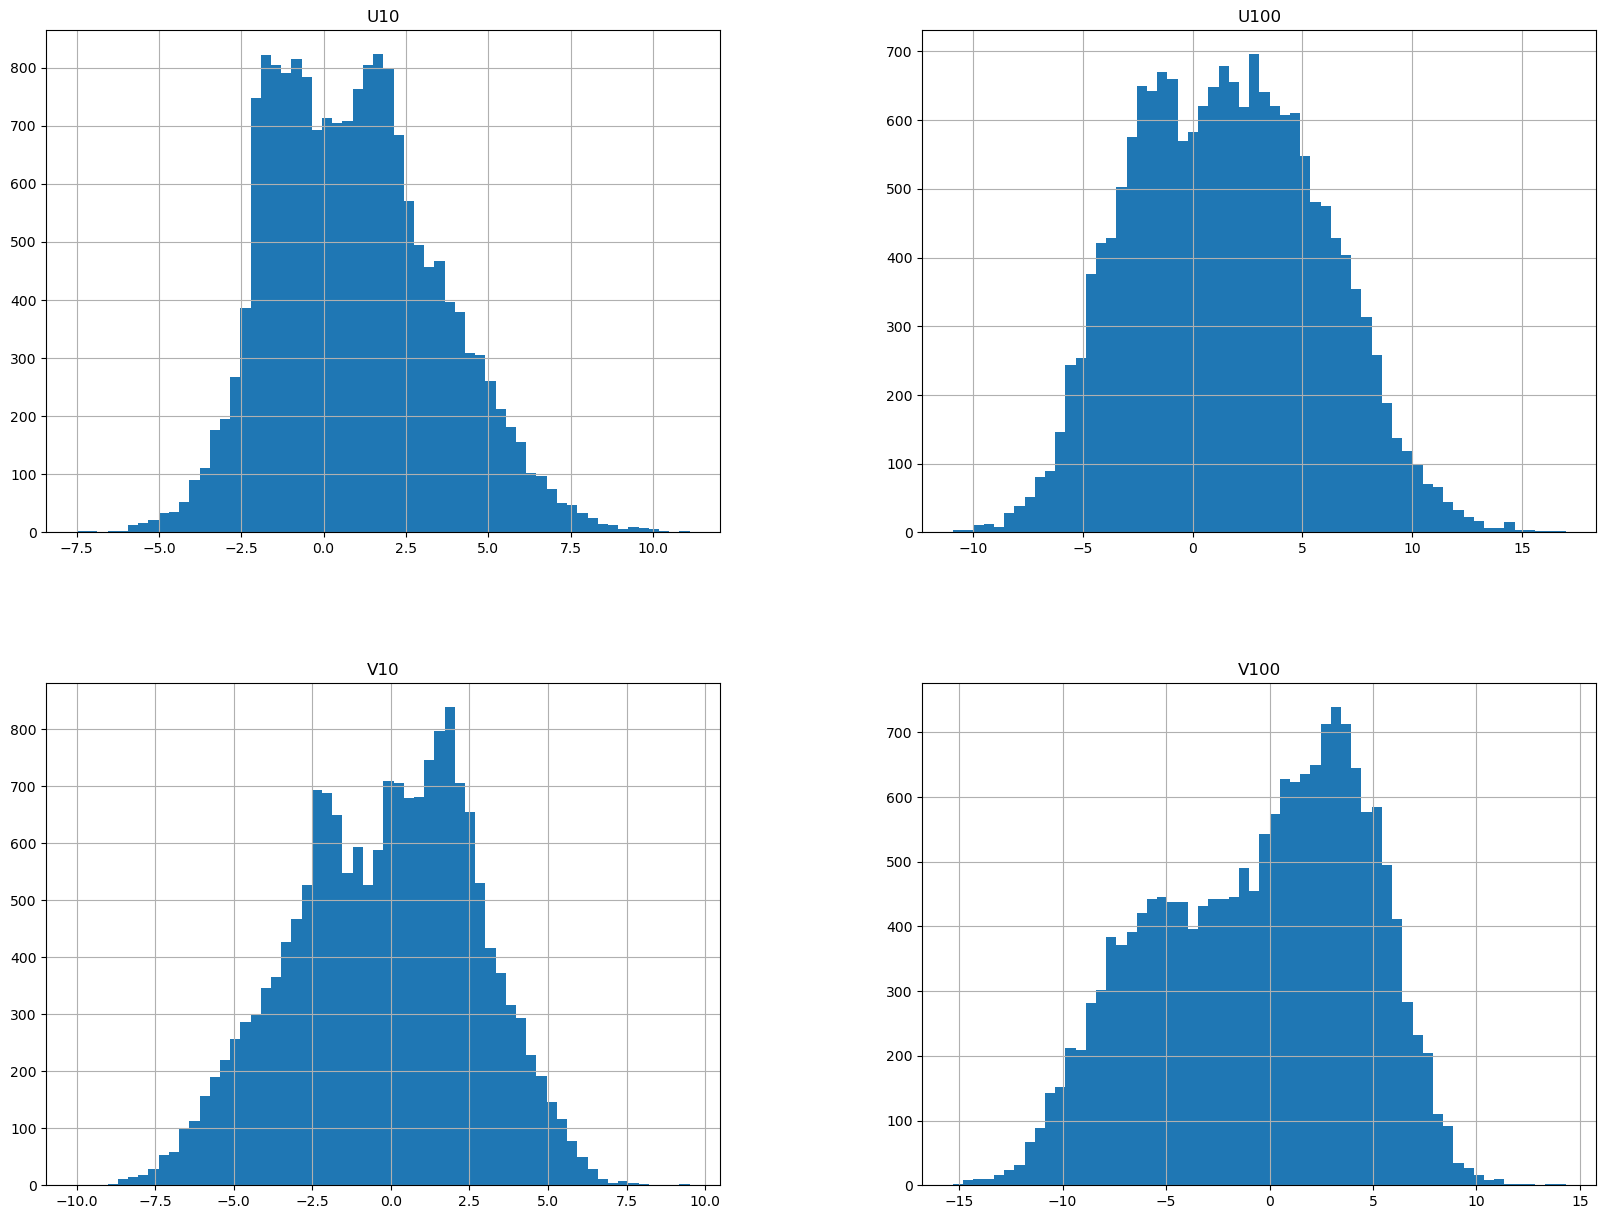

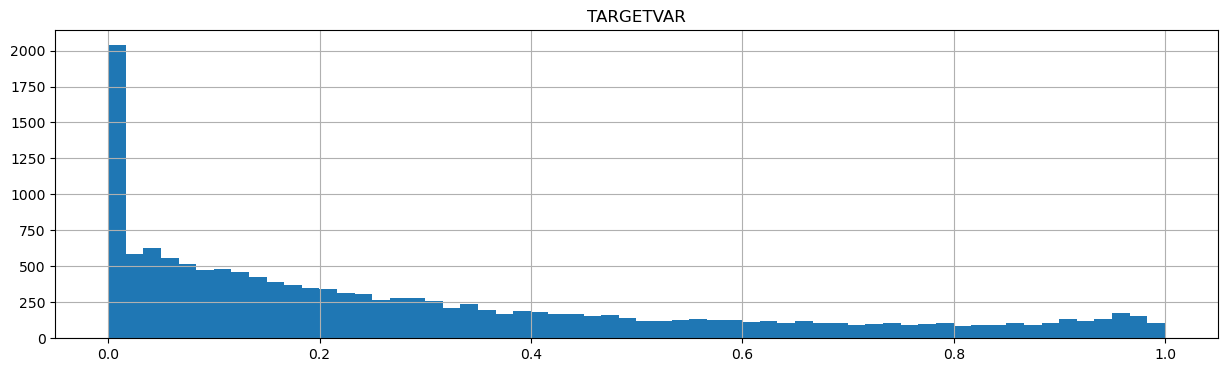

In [6]:
# -- HISTOGRAM --

# Extracting only relevant variables
dataset_X1_relevant = dataset_X1[["U10", "U100", "V10", "V100"]]
dataset_Y1_relevant = dataset_Y1[dataset_Y1["TARGETVAR"] >= 0]   # /!\ Removing test samples (y = -1) /!\
dataset_Y1_relevant = dataset_Y1_relevant[["TARGETVAR"]]

# Observing distributions
dataset_X1_relevant.hist(bins = 60, figsize = (20, 15))
dataset_Y1_relevant.hist(bins = 60, figsize = (15, 4))

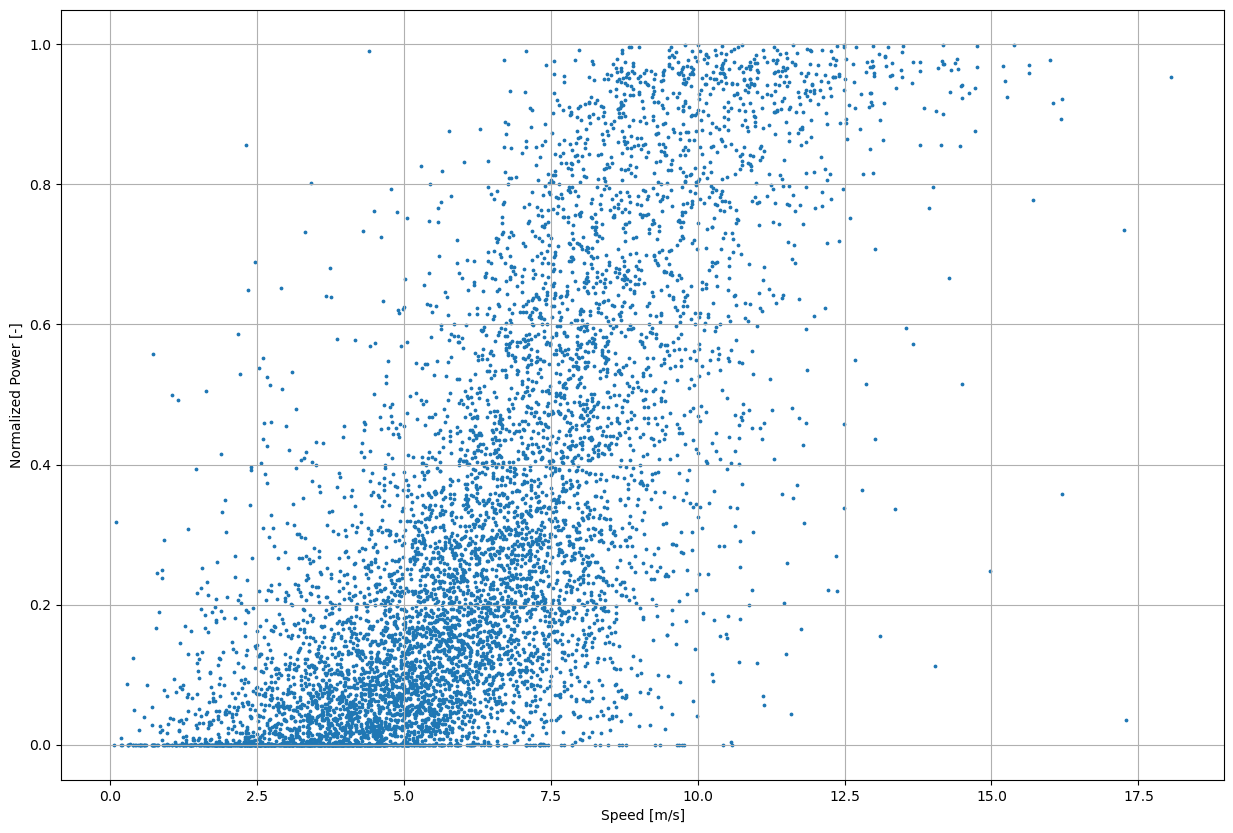

In [7]:
# -- OBSERVING WIND vs POWER --

# Removing test data
dataset_X_clean = dataset_X1[dataset_Y1["TARGETVAR"] >= 0]
dataset_Y_clean = dataset_Y1[dataset_Y1["TARGETVAR"] >= 0]

# Computing total wind speed
u_wind   = dataset_X_clean[["U100"]].to_numpy()
v_wind   = dataset_X_clean[["V100"]].to_numpy()
wind_tot = np.sqrt(u_wind**2 + v_wind**2)

# Retreiving power
power = dataset_Y_clean[["TARGETVAR"]].to_numpy()

# To see more clearly, one sample out of 2 is removed
for i in range(1):
    wind_tot = wind_tot[1::2]
    power    = power[1::2]

# Plotting
plt.figure(figsize=(15, 10))
plt.scatter(wind_tot, power, s = 3)
plt.grid()
plt.xlabel("Speed [m/s]")
plt.ylabel("Normalized Power [-]")
plt.show()

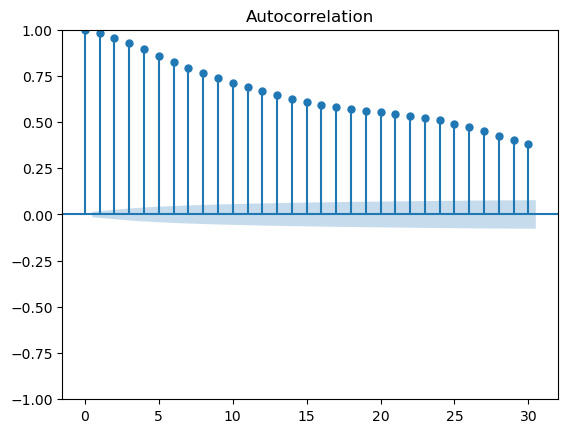

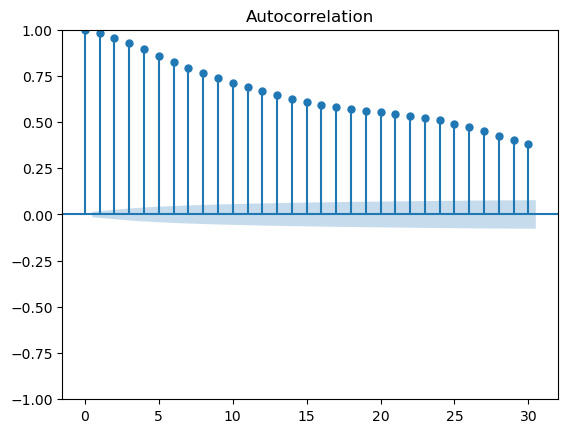

In [8]:
# -- OBSERVING AUTO-CORRELATION --

#plot_acf(dataset_X1["U10"], lags=30,bartlett_confint=False)
#plot_acf(dataset_X1["V10"], lags=30)
plot_acf(dataset_X1["U100"], lags=30)
#plot_acf(dataset_X1["V100"], lags=30)

[comment]: <> (Section)
<hr style="color:#a4342d;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#a4342d;">
    Dataset - Train & Test | DataLoader
    </b>
</p>
<hr style="color:#a4342d;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to explore further the dataset ! First, one needs to create a train and test set. Then, it is interestng to look for correlations, new variables and possible improvements to the current dataset. All the new datasets will be save in the datafolder and ready to use by our different models ! The functions available are:
</p>

In [7]:
# -- FUNCTIONS : MEAN, VARIANCE, ZONAL AVERAGE SPEED AND TIME STEPS --

# Used to compute the mean and variance of a variable over some timeslices in the dataset
def computeMeanVariance(datasets, 
                        variables = ["U100", "V100"],
                        window    = 100,
                        variance  = True):

    # Security
    assert window > 1, "Window size must be greater than 1 to compute mean and var"

    # Looping over all the datasets
    for d in datasets:

        # Looping over the variables whose mean and var must be computed
        for v in variables:

            # Retreiving data 
            data = d.loc[: , [v]].to_numpy()

            # Stores mean and variance (1st and 2nd : mean = their value, var = 0 otherwise NAN problem while computation)
            mean = [data[0][0], data[1][0]]
            var  = [0, 0]

            for i in range(2, len(data)):

                # Start and end index for computation
                index_start = i - window if i - window >= 0 else 0
                index_end   = i - 1 if i - 1 >= 0 else 0

                # Computing mean and variance (much faster using numpy variables)
                mean.append(np.mean(data[index_start:index_end]))
                var.append(np.var(data[index_start:index_end]))
            
            # Adding the new data to dataset
            d[f"{v}_mean"] = mean
            if variance:
                d[f"{v}_var"] = var

# Used to compute the instantenous mean and variance of a variable accross multiple datasets
def computeZonalValue(datasets, 
                      variables = ["U100", "V100"],
                      variance  = True):

    # Security
    assert len(datasets) > 1, "To compute mean and var, at least 2 datasets are needed"

    # Looping over the variables whose mean and var must be computed
    for v in variables:

        # Number of samples
        nb_samples = len(datasets[0])

        # Stores all the different values in numpy matrix for efficient computation
        data = np.zeros((nb_samples, len(datasets)))

        # Retreiving all the corresponding data
        for i, d in enumerate(datasets):
            
            # Squeeze is there to remove useless dimension (Ask Victor)
            data[:, i] = np.squeeze(d.loc[: , [v]].to_numpy())

        # Computing mean and variance (much faster using numpy variables)
        mean = np.mean(data, axis = 1) # Axis = 1 to make mean over each row
        var  = np.var(data, axis = 1)

        # Adding new data to all the datasets
        for d in datasets:
            d[f"{v}_mean"] = mean
            if variance:
                d[f"{v}_var"] = var

# Used to add the value taken by a given variable over the past samples
def addPastTime(datasets,
                variables = ["U100", "V100"],
                window    = 3):
    #
    # Note from Victor
    # This function was a pain in the ass to make ! Even I, am not sure why it works well :D
    #
    # Security
    assert window > 0, "Window size must be greater than 0 to add past samples"

    # Looping over the datasets
    for d in datasets:

        # Looping over the different columns
        for i, v in enumerate(variables):

            # Retrieving current data
            data = d[[v]].to_numpy()

            # Stores all the past results
            former_data = np.zeros((len(data), window))

            # Looping over the corresponding data
            for j in range(len(data)):

                # Start and end index for retreiving values
                index_start = j - window if j - window >= 0 else 0
                index_end   = j if j - 1 >= 0 else 0
                
                # Retrieve corresponding value
                values = data[index_start:index_end]

                # Fixing case where looking at starting indexes < window size
                if len(values) != window:
                    values = np.append(np.zeros((window - len(values), 1)), values) # here attention

                # Placing the data (such that by reading left to right: t - 1, t - 2, t - 3, ...)
                for k, val in enumerate(values):
                        former_data[j][k] = val

            # Addding past results in the dataset
            for t in range(window):
                d[f"{v}_(t-{window - t})"] = former_data[:, t]

# Used to normalize the data of different variables
def normalize(datasets,
              norm_type = "argmax",
              data_type = "column",
              variables = ["U10", "V10", "U100", "V100"]):
    """
    Documentation :
        - norm_type (str) : argmax, mean, WSmax, WSmean
            - Normalize using the argmax or by using the mean and std of the data
        - data_type (str) : column, all
            - Apply the normalization using norm_type computed either on a unique column or all the same columns
    """
    # Security
    assert norm_type in ["argmax", "mean"], "Normalization types = argmax, mean"
    assert data_type in ["column", "all"] , "Data types = column, all"

    # Initialization of the normalization variables
    argmax, mean, std = list(), list(), list()

    # 1 - Computing argmax or mean and std of all datasets
    if data_type == "all":

        # Looping over the different variables to normalize
        for i, v in enumerate(variables):

            # Initialization of the normalization variables
            argmax_list, mean_list, std_list = list(), list(), list()

            # Looping over all the datasets
            for d in datasets:

                # Retrieving currently observed data
                current_data = d[[v]].to_numpy()

                # Retrieving variables
                argmax_list.append(np.max(np.abs(current_data)))
                mean_list.append(np.mean(current_data))
                std_list.append(np.std(current_data))

                

            # Adding results
            argmax.append(max(argmax_list))
            mean.append(sum(mean_list)/len(mean_list))
            std.append(sum(std_list)/len(std_list))
    
    # 2 - Normalization of the datasets
    for d in datasets:

        # Looping over the different columns
        for i, v in enumerate(variables):
            
            # Case 1 - Mean and std - Column
            if norm_type == "mean" and data_type == "column":
                data         = d[[v]].to_numpy()
                d[v] = (data - np.mean(data))/np.std(data)

            # Case 2 - Mean and std - All
            elif norm_type == "mean" and data_type == "all":
                data         = d[[v]].to_numpy()
                d[v] = (data - mean[i])/std[i]
            
            # Case 3 - Argmax - Column
            elif norm_type == "argmax" and data_type == "column":
                data = d[[v]].to_numpy()
                d[v] = data/np.max(data)

            # Case 4 - Argmax - All
            else:
                data = d[[v]].to_numpy()
                d[v] = data/argmax[i]

# Used to remove specific columns from the dataset
def remove(datasets, variables):

    # Looping over all datasets and variables
    for d in datasets:
        for v in variables:

            # Removing
            d.drop(v, inplace = True, axis = 1)


# Used to retrieve the wind direction and the wind speed from
# meridional and zonal comp and add them in the dataset
def wind_comp(datasets):
  
    # Find the speed speed and the wind direction
    for d in datasets:
        w_u_10 = d["U10"].to_numpy()
        w_v_10 = d["V10"].to_numpy()

        # w_s stands for wind speed
        d["WS10"]         = np.sqrt(np.square(w_u_10) + np.square(w_v_10))
        d["WS_direction"] = np.arctan2(w_v_10/w_u_10)

        w_u_100 = d["U100"].to_numpy()
        w_v_100 = d["V100"].to_numpy()

        d["WS100"]        = np.sqrt(np.square(w_u_100) + np.square(w_v_100))
        d["WS_direction"] = np.arctan2(w_v_100/w_u_100)
           

"""
def jean_baptiste_joseph_fourier(og_datasets, variables):
    # og_datasets are the original datasets of all zones

    # 1. Compute the fourier transform on the original dataset
    # Do it for each variable
    

    # Looping over all datasets and variables
    for d in og_datasets:
        x = np.arange(len(d)) # hours

        # Looping over the different columns
        for i, v in enumerate(variables):
            data = d[[v]].to_numpy()
            d[[v]] = abs(fft(data))
"""

In [72]:
# -- DATA LOADER -- 
# This class has for purpose to handle the data and make our life easier ! 
#
class dataLoader():
    
    # Initialization of the loader
    def __init__(self, datasets_X, datasets_Y):

        # Stores the original, transformed and final datasets
        self.original_datasets_X    = datasets_X
        self.original_datasets_Y    = datasets_Y
        self.transformed_datasets_X = datasets_X
        self.transformed_datasets_Y = datasets_Y
        self.final_dataset_X        = None
        self.final_dataset_Y        = None

        # Used to know if datasets have been combined or not
        self.isCombined = None

    # Used to display the head of the transformed dataset (first set)
    def showHeadTransformed(self):
        section("Dataset - X - Transformed")
        print(self.transformed_datasets_X[0].head())
        section("Dataset - Y - Transformed")
        print(self.transformed_datasets_Y[0].head())

    # Used to split the final dataset into a train and test set (In test set, values for y are equal to -1)
    def splitTrainTest(self, save = False, save_dir = "new_data"):

        # Security
        assert self.isCombined != None, "You must first use self.finalize"

        # Case 1 - Datasets have been combined all together
        if self.isCombined == True:
            X_train = self.final_dataset_X[self.final_dataset_Y['TARGETVAR'] != -1]
            Y_train = self.final_dataset_Y[self.final_dataset_Y['TARGETVAR'] != -1]
            X_test  = self.final_dataset_X[self.final_dataset_Y['TARGETVAR'] == -1]
            Y_test  = self.final_dataset_Y[self.final_dataset_Y['TARGETVAR'] == -1] # Not useful, I know !

        # Case 2 - Datasets are still separated
        if self.isCombined == False:
            
            X_train, Y_train, X_test, Y_test = list(), list(), list(), list()

            # Looping over all the small datasets
            for x, y in zip(self.final_dataset_X, self.final_dataset_Y):
                X_train.append(x[y['TARGETVAR'] != -1])
                Y_train.append(y[y['TARGETVAR'] != -1])
                X_test.append(x[y['TARGETVAR'] == -1])
                Y_test.append(y[y['TARGETVAR'] == -1])

        # Be careful with the order
        return X_train, X_test, Y_train, Y_test
        
    # Used to perfom final operation on dataset (Combining everything or storing them separately)
    def finalization(self, dataset_type = "combined"):

        # Security
        assert dataset_type in ["combined", "separated"], "The final dataset can either be of type combined or separated"

        # Case 1 - Combining into one big dataset
        if dataset_type == "combined":
            self.final_dataset_X = pd.concat(self.transformed_datasets_X)
            self.final_dataset_Y = pd.concat(self.transformed_datasets_Y)
            self.isCombined = True

        # Case 2 - Separated datasets
        else:
            self.final_dataset_X = self.transformed_datasets_X
            self.final_dataset_Y = self.transformed_datasets_Y
            self.isCombined = False

    #--------------------------------------------------------------------------------
    #                                    PIPELINES
    #--------------------------------------------------------------------------------
    #
    # List of functions available:
    #
    # - computeMeanVariance(datasets, variables = ≈, window = 100, variance  = True)
    #
    # - computeZonalValue(datasets, variables = ["U100", "V100"], variance  = True)
    # 
    # - addPastTime(datasets, variables = ["U100", "V100"], window = 3):
    #
    # - normalize(datasets, norm_type = "argmax", data_type = "column", variables = ["U100", "V100"])
    #
    def pipeline(self, useMeanVariance = True, var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24 * 7,
                       useZonal        = True, var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,
                       usePastTime     = True, var_PT   = ["U10", "V10", "U100", "V100"], window_ZON   = 3,
                       useNormalize    = True, var_NORM = ["U10", "V10", "U100", "V100"], norm_type = "argmax", data_type = "column"):

        # Copying original dataset
        dX = copy.deepcopy(self.original_datasets_X)
        dY = copy.deepcopy(self.original_datasets_Y)

        # Applying the different transformations
        if useNormalize:
            normalize(dX, variables = var_NORM, norm_type = norm_type, data_type = data_type)
        if useMeanVariance:
            computeMeanVariance(dX, variables = var_MV, window = window_MV, variance = variance_MV)
        if useZonal:
            computeZonalValue(dX, variables = var_ZON, variance = variance_ZON)
        if usePastTime:
            addPastTime(dX, variables = var_PT, window = window_ZON)

        # Updating dataset
        self.transformed_datasets_X = dX
        self.transformed_datasets_Y = dY

        # Making sure one has to finalize again
        self.isCombined = None

<AxesSubplot: >

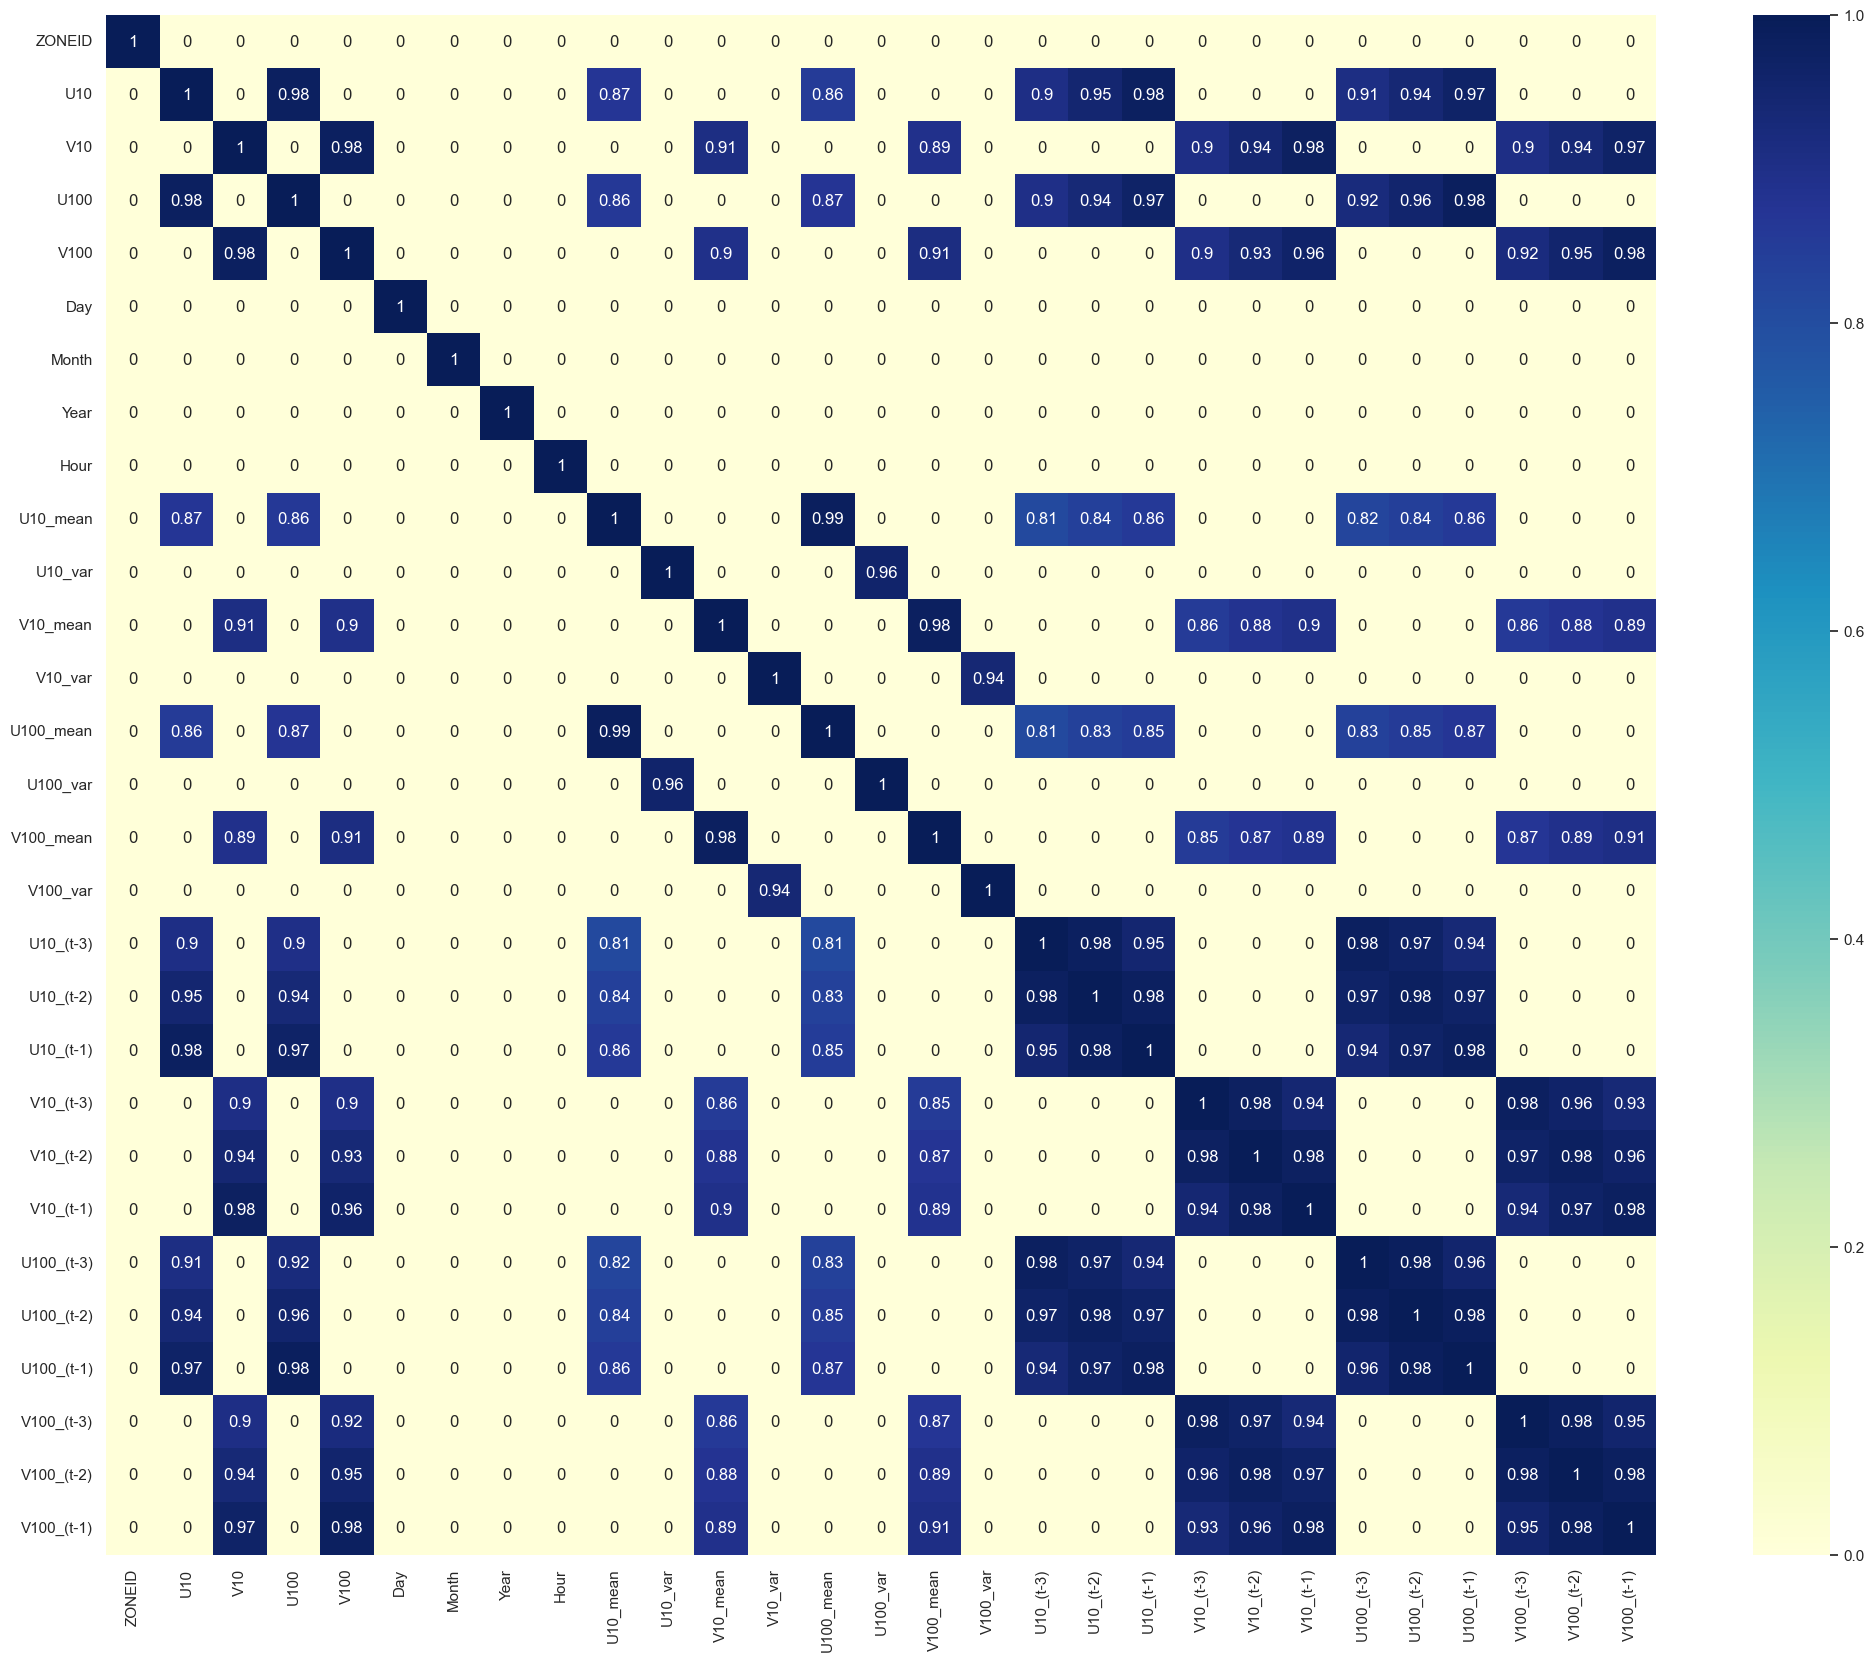

In [9]:
# -- GAINING INSIGHTS (2) - ARGMAX ALL -- 
#
# Treshold value for removing correlation
tresh_corr = 0.3

# Initialization of the loader
loader_2 = dataLoader(dataset_original_X, dataset_original_Y)

# Aplying the first prototype of pipeline (Mean value on 30 days)
loader_2.pipeline(norm_type = "argmax", data_type = "all")

# Combine all the small datasets into a big one
loader_2.finalization(dataset_type = "combined")

# Retreives the train and test set (in Pandas frame)
data_X_2, _, _, _ = loader_2.splitTrainTest()

# -- Correlation matrix -- 
corr_2             = data_X_2.corr()
corr_2[np.abs(corr_2) < tresh_corr] = 0
sns.set(rc={'figure.figsize':(25, 20)})
sns.heatmap(corr_2, cmap = "YlGnBu", annot = True)

<AxesSubplot: >

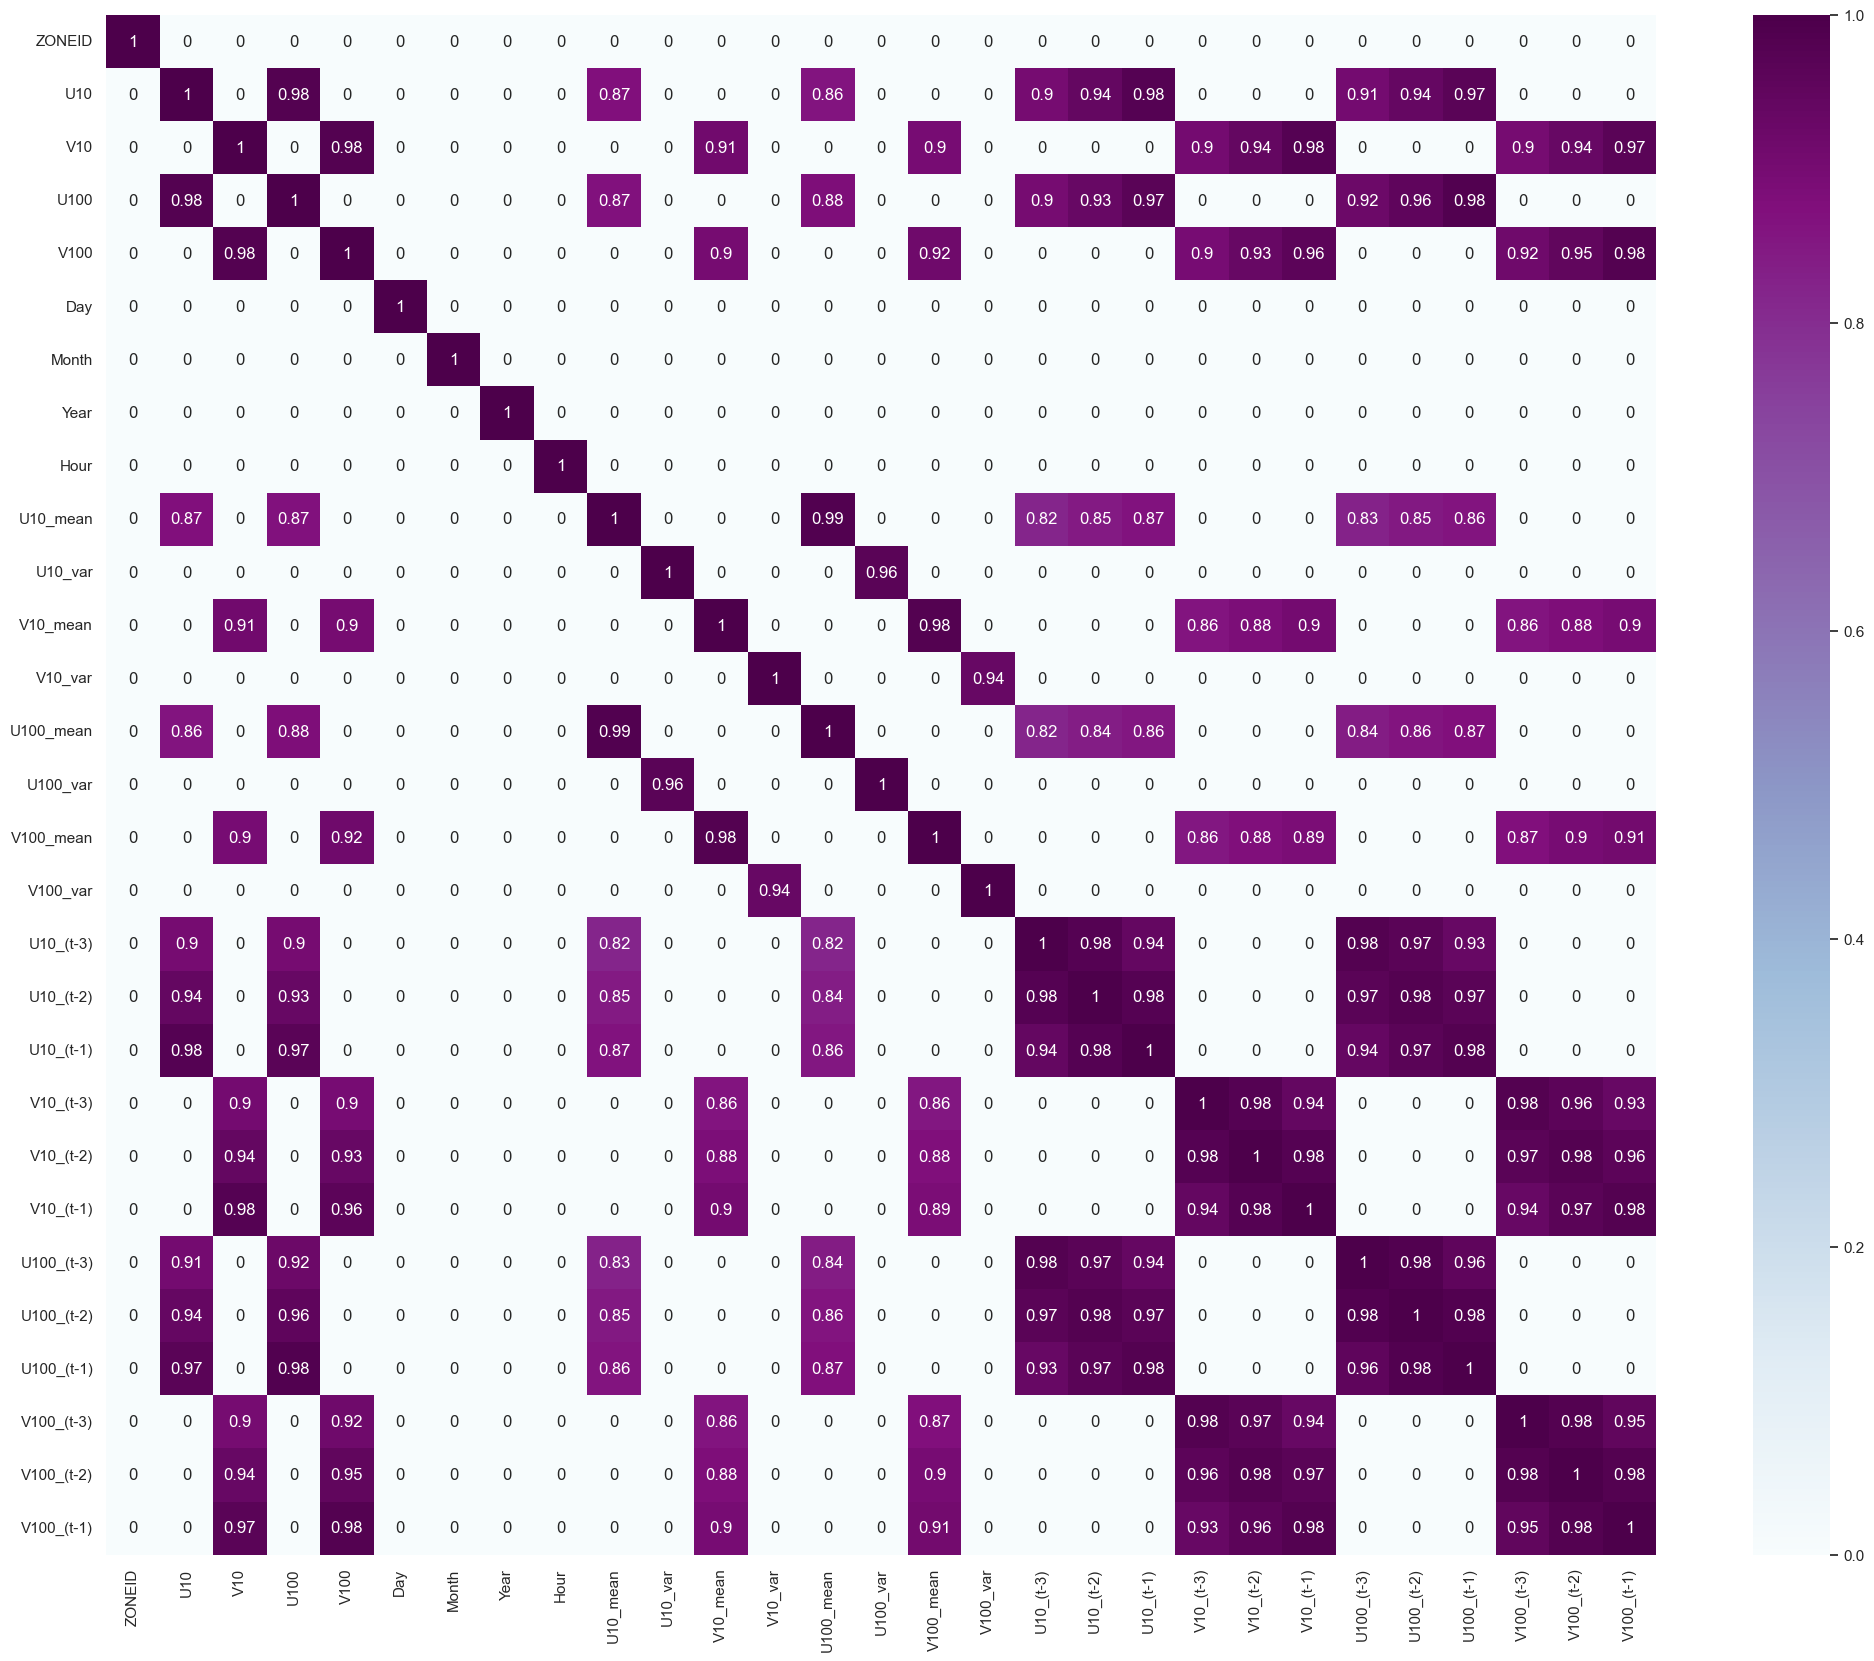

In [10]:
# -- GAINING INSIGHTS (3) - MEAN COLUMN -- 
#
# Treshold value for removing correlation
tresh_corr = 0.3

# Initialization of the loader
loader_3 = dataLoader(dataset_original_X, dataset_original_Y)

# Aplying the first prototype of pipeline (Mean value on 30 days)
loader_3.pipeline(norm_type = "mean", data_type = "column")

# Combine all the small datasets into a big one
loader_3.finalization(dataset_type = "combined")

# Retreives the train and test set (in Pandas frame)
data_X_3, _, _, _ = loader_3.splitTrainTest()

# -- Correlation matrix -- 
corr_3             = data_X_3.corr()
corr_3[np.abs(corr_3) < tresh_corr] = 0
sns.set(rc={'figure.figsize':(25, 20)})
sns.heatmap(corr_3, cmap = "BuPu", annot = True)

<AxesSubplot:>

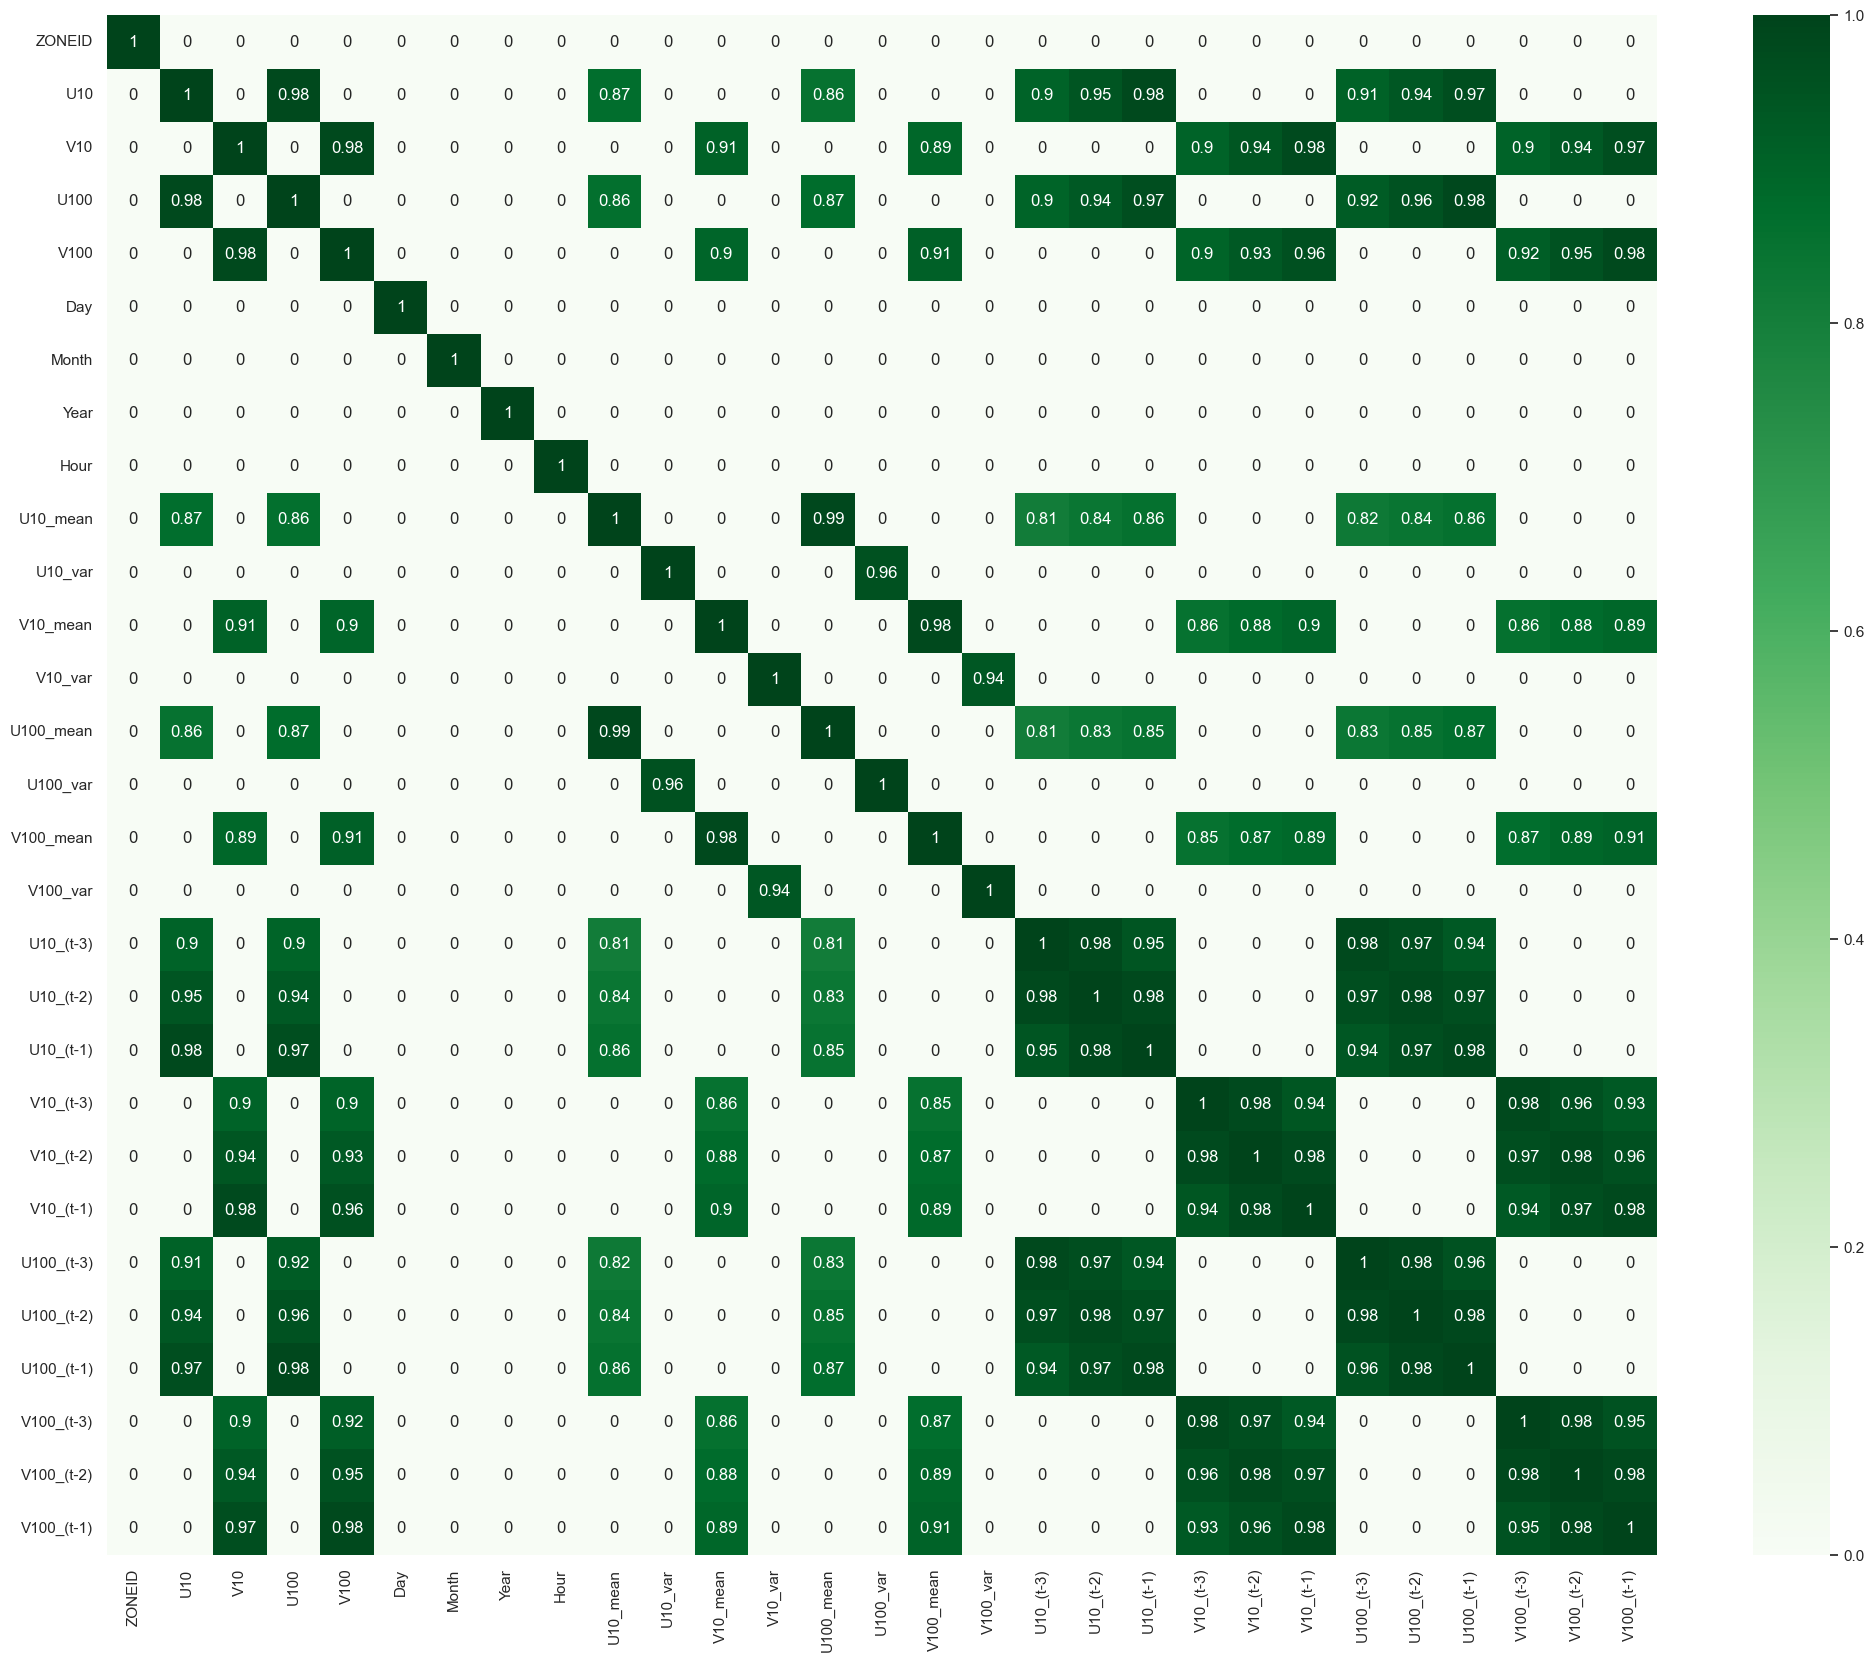

In [84]:
# -- GAINING INSIGHTS (4) - MEAN ALL -- 
#
# Treshold value for removing correlation
tresh_corr = 0.3

# Initialization of the loader
loader_4 = dataLoader(dataset_original_X, dataset_original_Y)

# Aplying the first prototype of pipeline (Mean value on 30 days)
loader_4.pipeline(norm_type = "mean", data_type = "all")

# Combine all the small datasets into a big one
loader_4.finalization(dataset_type = "combined")

# Retreives the train and test set (in Pandas frame)
data_X_4, _, _, _ = loader_4.splitTrainTest()

# -- Correlation matrix -- 
corr_4             = data_X_4.corr()
corr_4[np.abs(corr_4) < tresh_corr] = 0
sns.set(rc={'figure.figsize':(25, 20)})
sns.heatmap(corr_4, cmap = "Greens", annot = True)

In [12]:
# -- CORRELATION MATRIX COMPARISON --
corr_21 = corr_2 - corr_1
sns.set(rc={'figure.figsize':(25, 20)})
sns.heatmap(corr_21, cmap = "Greens", annot = True)

plt.figure()
corr_23 = corr_2 - corr_3
sns.set(rc={'figure.figsize':(25, 20)})
sns.heatmap(corr_23, cmap = "BuPu", annot = True)

plt.figure()
corr_24 = corr_2 - corr_4
sns.set(rc={'figure.figsize':(25, 20)})
sns.heatmap(corr_24, cmap = "YlGnBu", annot = True)

plt.figure()
corr_31 = corr_3 - corr_1
corr_31[np.abs(corr_31) < 0.2] = 0
sns.set(rc={'figure.figsize':(25, 20)})
sns.heatmap(corr_31, cmap = "BuPu", annot = True)

NameError: name 'corr_1' is not defined

In [13]:
# Template
"""
loader.pipeline(useMeanVariance = True, var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24 * 7,
                useZonal        = True, var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,
                usePastTime     = True, var_PT   = ["U10", "V10", "U100", "V100"], window_ZON = 3,
                useNormalize    = True, var_NORM = ["U10", "V10", "U100", "V100"], norm_type = "argmax", data_type = "column")
"""

'\nloader.pipeline(useMeanVariance = True, var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24 * 7,\n                useZonal        = True, var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,\n                usePastTime     = True, var_PT   = ["U10", "V10", "U100", "V100"], window_ZON = 3,\n                useNormalize    = True, var_NORM = ["U10", "V10", "U100", "V100"], norm_type = "argmax", data_type = "column")\n'

In [14]:
# Initialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

In [15]:
# TYPE 1 - ORIGINAL
loader.pipeline(useMeanVariance = False,
                useZonal        = False,
                usePastTime     = False,
                useNormalize    = False)
loader.finalization()

data_X0, submit_X0, data_Y0, submit_Y0 = loader.splitTrainTest()
print(data_X0.head())

   ZONEID       U10       V10      U100      V100  Day  Month  Year  Hour
0       1  2.124600 -2.681966  2.864280 -3.666076    1      1  2012     1
1       1  2.521695 -1.796960  3.344859 -2.464761    1      1  2012     2
2       1  2.672210 -0.822516  3.508448 -1.214093    1      1  2012     3
3       1  2.457504 -0.143642  3.215233 -0.355546    1      1  2012     4
4       1  2.245898  0.389576  2.957678  0.332701    1      1  2012     5


In [16]:
# TYPE 2 - INFLUENCE OF NORMALIZATION
loader.pipeline(useMeanVariance = False,
                useZonal        = False,
                usePastTime     = False,
                useNormalize    = True, norm_type = "argmax", data_type = "column")
                
loader.finalization()
data_X1, submit_X1, data_Y1, submit_Y1 = loader.splitTrainTest()
print(data_X1.head())

loader.pipeline(useMeanVariance = False,
                useZonal        = False,
                usePastTime     = False,
                useNormalize    = True, norm_type = "argmax", data_type = "all")
                
loader.finalization()
data_X2, submit_X2, data_Y2, submit_Y2 = loader.splitTrainTest()
print(data_X2.head())

loader.pipeline(useMeanVariance = False,
                useZonal        = False,
                usePastTime     = False,
                useNormalize    = True, norm_type = "mean", data_type = "column")
                
loader.finalization()
data_X3, submit_X3, data_Y3, submit_Y3 = loader.splitTrainTest()
print(data_X3.head())

loader.pipeline(useMeanVariance = False,
                useZonal        = False,
                usePastTime     = False,
                useNormalize    = True, norm_type = "mean", data_type = "all")
                
loader.finalization()
data_X4, submit_X4, data_Y4, submit_Y4 = loader.splitTrainTest()
print(data_X4.head())

   ZONEID       U10       V10      U100      V100  Day  Month  Year  Hour
0       1  0.191112 -0.282051  0.168602 -0.256111    1      1  2012     1
1       1  0.226832 -0.188979  0.196891 -0.172187    1      1  2012     2
2       1  0.240371 -0.086501  0.206520 -0.084816    1      1  2012     3
3       1  0.221058 -0.015106  0.189260 -0.024838    1      1  2012     4
4       1  0.202023  0.040970  0.174100  0.023242    1      1  2012     5
   ZONEID       U10       V10      U100      V100  Day  Month  Year  Hour
0       1  0.143194 -0.207525  0.133851 -0.185230    1      1  2012     1
1       1  0.169958 -0.139045  0.156309 -0.124533    1      1  2012     2
2       1  0.180102 -0.063645  0.163953 -0.061343    1      1  2012     3
3       1  0.165632 -0.011115  0.150251 -0.017964    1      1  2012     4
4       1  0.151370  0.030145  0.138215  0.016810    1      1  2012     5
   ZONEID       U10       V10      U100      V100  Day  Month  Year  Hour
0       1  0.463789 -0.849096  0.30464

In [17]:
# -- Datasets --
data_X_tot = [data_X0, data_X1, data_X2, data_X3, data_X4]
data_Y_tot = [data_Y0, data_Y1, data_Y2, data_Y3, data_Y4]

[comment]: <> (Section)
<hr style="color:#a4342d;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#a4342d;">
    Model - Creation of a pre-classifier
    </b>
</p>
<hr style="color:#a4342d;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to create a regression tree which allow us to determine wheter or not power will be produced.
</p>

In [ ]:
# -- CREATION OF THE DATASETS FOR PRE-CLASSIFIER --
# 
# Contains the new datasets
data_X_PRE = copy.deepcopy(data_X4)
data_Y_PRE = copy.deepcopy(data_Y4)

# Transforming into binary classification problem (0 = no power, 1 = power to predict)
data_Y_PRE[data_Y_PRE["TARGETVAR"] != 0] = 1

# Removing useless information (apparently not that useless ahah)
# data_X_PRE.drop(["Day", "Month", "Year", "Hour", "ZONEID"], inplace = True, axis = 1)

# Final conversion
data_X_PRE = data_X_PRE.to_numpy()
data_Y_PRE = data_Y_PRE["TARGETVAR"].to_numpy()

# Generation of the train and test
X_PRE_train, X_PRE_test, y_PRE_train, y_PRE_test = train_test_split(data_X_PRE, data_Y_PRE, test_size = 0.3, random_state = 69)

In [ ]:
# -- TRAINING AND TESTING OF THE PRE-CLASSIFIER -- 
#
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor

# Initialization of the model
model_pre_classifier = tree.DecisionTreeClassifier(max_depth = 10)

# Fitting
model_pre_classifier.fit(X_PRE_train, y_PRE_train)

# Accuracy 
accuracy_pre_classifier = model_pre_classifier.score(X_PRE_test, y_PRE_test)

print(f"Pre classifier's accuracy [%] : {accuracy_pre_classifier * 100}")

In [ ]:
p = model_pre_classifier.predict_proba(X_PRE_test)

print(p[100:130])

In [ ]:
# -- CLASS OF ENSEMBLE MODEL --
#
# The goal of this class is to create our own predict function which is composed of 2 main steps:
# - The pre-classifier's determines whether or not the wind is sufficiently high to have a power creation
# - The model which predicts the power creation
class ModelEnsemble():

    # Initialization of the ensemble model
    def __init__(self, model_prec_classifier, model_trained):
        self.pre_classifier = model_prec_classifier
        self.trained        = model_trained 
    
    # Used to compute predictions
    def predict(self, x, predict_treshold = 0.9):

        # 1 - Determining if there is power or not 
        PC_results  = self.pre_classifier.predict_proba(x)

        # 2 - Power predictions
        MOD_results = self.trained.predict(x)

        # 3 - Replacing predictions with pre-classifier results 
        for i, r in enumerate(PC_results):
            MOD_results[i] = 0 if r[0] > predict_treshold else MOD_results[i]

        return MOD_results



In [ ]:
# -- TESTING
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Creation of the models
model_simple = RandomForestRegressor(max_depth = 40, n_estimators = 20)

X = data_X0.to_numpy()
y = data_Y0[["TARGETVAR"]].to_numpy().ravel()

# Generation of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

# Fitting the model on current split
model_simple.fit(X_train, y_train)

# Creation of the complex model
model_complexe = ModelEnsemble(model_pre_classifier, model_simple)

In [ ]:
# Computing predictions
pred_simple  = model_simple.predict(X_test)
pred_complex = model_complexe.predict(X_test, predict_treshold = 0.9)

# Computing and comparing accuracies
acc_simple  = mean_squared_error(pred_simple, y_test,  squared = "False")
acc_complex = mean_squared_error(pred_complex, y_test, squared = "False")

print(acc_simple)
print(acc_complex)

[comment]: <> (Section)
<hr style="color:#a4342d;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#a4342d;">
    Model - Training & Testing
    </b>
</p>
<hr style="color:#a4342d;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to explore further the dataset ! First, one needs to create a train and test set. Then, it is interesitng to look for correlations, new variables and possible improvements to the current dataset. All the new datasets will be save in the datafolder and ready to use by our different models ! The functions available are:
</p>

In [110]:
# -- FUNCTIONS --
#
# Used to compute a model's accuracy against different datasets
def modelTesting(datasets_X, datasets_y, model, test_size = 0.3, random_state = 69):
    
    # Contains mean accuracy of the model against each dataset
    accuracy_train = []
    accuracy_test = []

    # Looping over whole the different datasets
    for X, y in zip(datasets_X, datasets_y):
        
        # Final conversion (Numpy and retrieving targets)
        X = X.to_numpy()
        y = y[["TARGETVAR"]].to_numpy().ravel()

        # Retrieving datasets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

        # Fitting the model on current split
        model.fit(X_train, y_train)

        
        # Accuracy
        accuracy_train.append(model.score(X_train, y_train))
        accuracy_test.append(model.score(X_test, y_test))

    return accuracy_train, accuracy_test

def modelPlotResults(parameters, acc_train, acc_test, xlabel = "UNKNOWN", param_name = "UNKNOWN", fontsize = 15, save_path = "graphs/"):

    # 1 - Evolution of the test accuracy
    plt.figure()
    sns.set(font_scale = 2)

    # Plotting evolution curve for a specific dataset with varying parameter value
    for i, a in enumerate(acc_test):
        plt.plot(parameters, [a_i * 100 for a_i in a], label = f"Dataset n°{i}", linewidth = 5)
    
    plt.legend(loc="upper right", fontsize = fontsize)
    plt.ylabel("Accuracy [%]", fontsize = fontsize)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.savefig(f"{save_path}_1.png")
    plt.show()

    # 2 - Bar plot
    acc_test_best  = []
    acc_train_best = []
    k_best         = []

    # Looping over accuracies to find best results
    for a1, a2 in zip(acc_train, acc_test):

        # Finding best test accuracy
        max_value = max(a2)
        max_index = a2.index(max_value)

        # Adding results
        acc_test_best.append(max_value)
        acc_train_best.append(a1[max_index])
        k_best.append(parameters[max_index])

    # Contains x-axis labels
    x_ax_labels = [f"Dataset n°{i} - {param_name} = {k_best[i]}" for i in range(len(acc_train))]

    # Used to make x-axis    
    index = [i for i in range(len(acc_train))]

    # Plotting the results
    plt.figure()
    plt.bar([i - 0.2 for i in index], [a_i * 100 for a_i in acc_train_best], 0.4, label = "Train")
    plt.bar([i + 0.2 for i in index], [a_i * 100 for a_i in acc_test_best], 0.4, label = "Test")
    plt.xticks(index, x_ax_labels)
    plt.ylabel("Accuracy [%]", fontsize = fontsize)
    plt.legend()
    plt.savefig(f"{save_path}_2.png")
    plt.show()



<hr style="color:#a4342d; width: 145px;" align="left">
<p style="color:#a4342d;">KNeighborsRegressor</p>
<hr style="color:#a4342d; width: 145px;" align="left">

In [ ]:
# -- Generating results KNN -- 
'''
from sklearn.neighbors import KNeighborsRegressor

# Definition of the parameters to be tested
k_param = np.arange(1, 100, 10, dtype = int)

# Stores the accuracy of the training and testing
knn_accuracy_train = [[] for i in range(len(data_X_tot))]
knn_accuracy_test  = [[] for i in range(len(data_X_tot))]

for k in k_param:

    # Initialization of the model
    model = KNeighborsRegressor(n_neighbors = k)

    # Computing accuracies on all the datasets
    acc_train, acc_test = modelTesting(data_X_tot, data_Y_tot, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        knn_accuracy_train[i].append(acc_1)
        knn_accuracy_test[i].append(acc_2)

In [ ]:
modelPlotResults(k_param, knn_accuracy_train, knn_accuracy_test, 
                 xlabel = "Number of neighbors - $k$ [-]", fontsize = 30, 
                 param_name = "k", save_path = "graphs/knn/knn")

: 

<hr style="color:#a4342d; width: 100px;" align="left">
<p style="color:#a4342d;">Random Forest</p>
<hr style="color:#a4342d; width: 100px;" align="left">

In [19]:
# -- Generating results Random Forest -- 
from sklearn.ensemble import RandomForestRegressor

# Definition of the parameters to be tested
max_depth = np.linspace(1, 60, 60)

# Stores the accuracy of the training and testing
rf_accuracy_train = [[] for i in range(len(data_X_tot))]
rf_accuracy_test  = [[] for i in range(len(data_X_tot))]

for d in max_depth:

    # Initialization of the model
    model = RandomForestRegressor(max_depth = d, n_estimators = 20)

    # Computing accuracies on all the datasets
    acc_train, acc_test = modelTesting(data_X_tot, data_Y_tot, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        rf_accuracy_train[i].append(acc_1)
        rf_accuracy_test[i].append(acc_2)

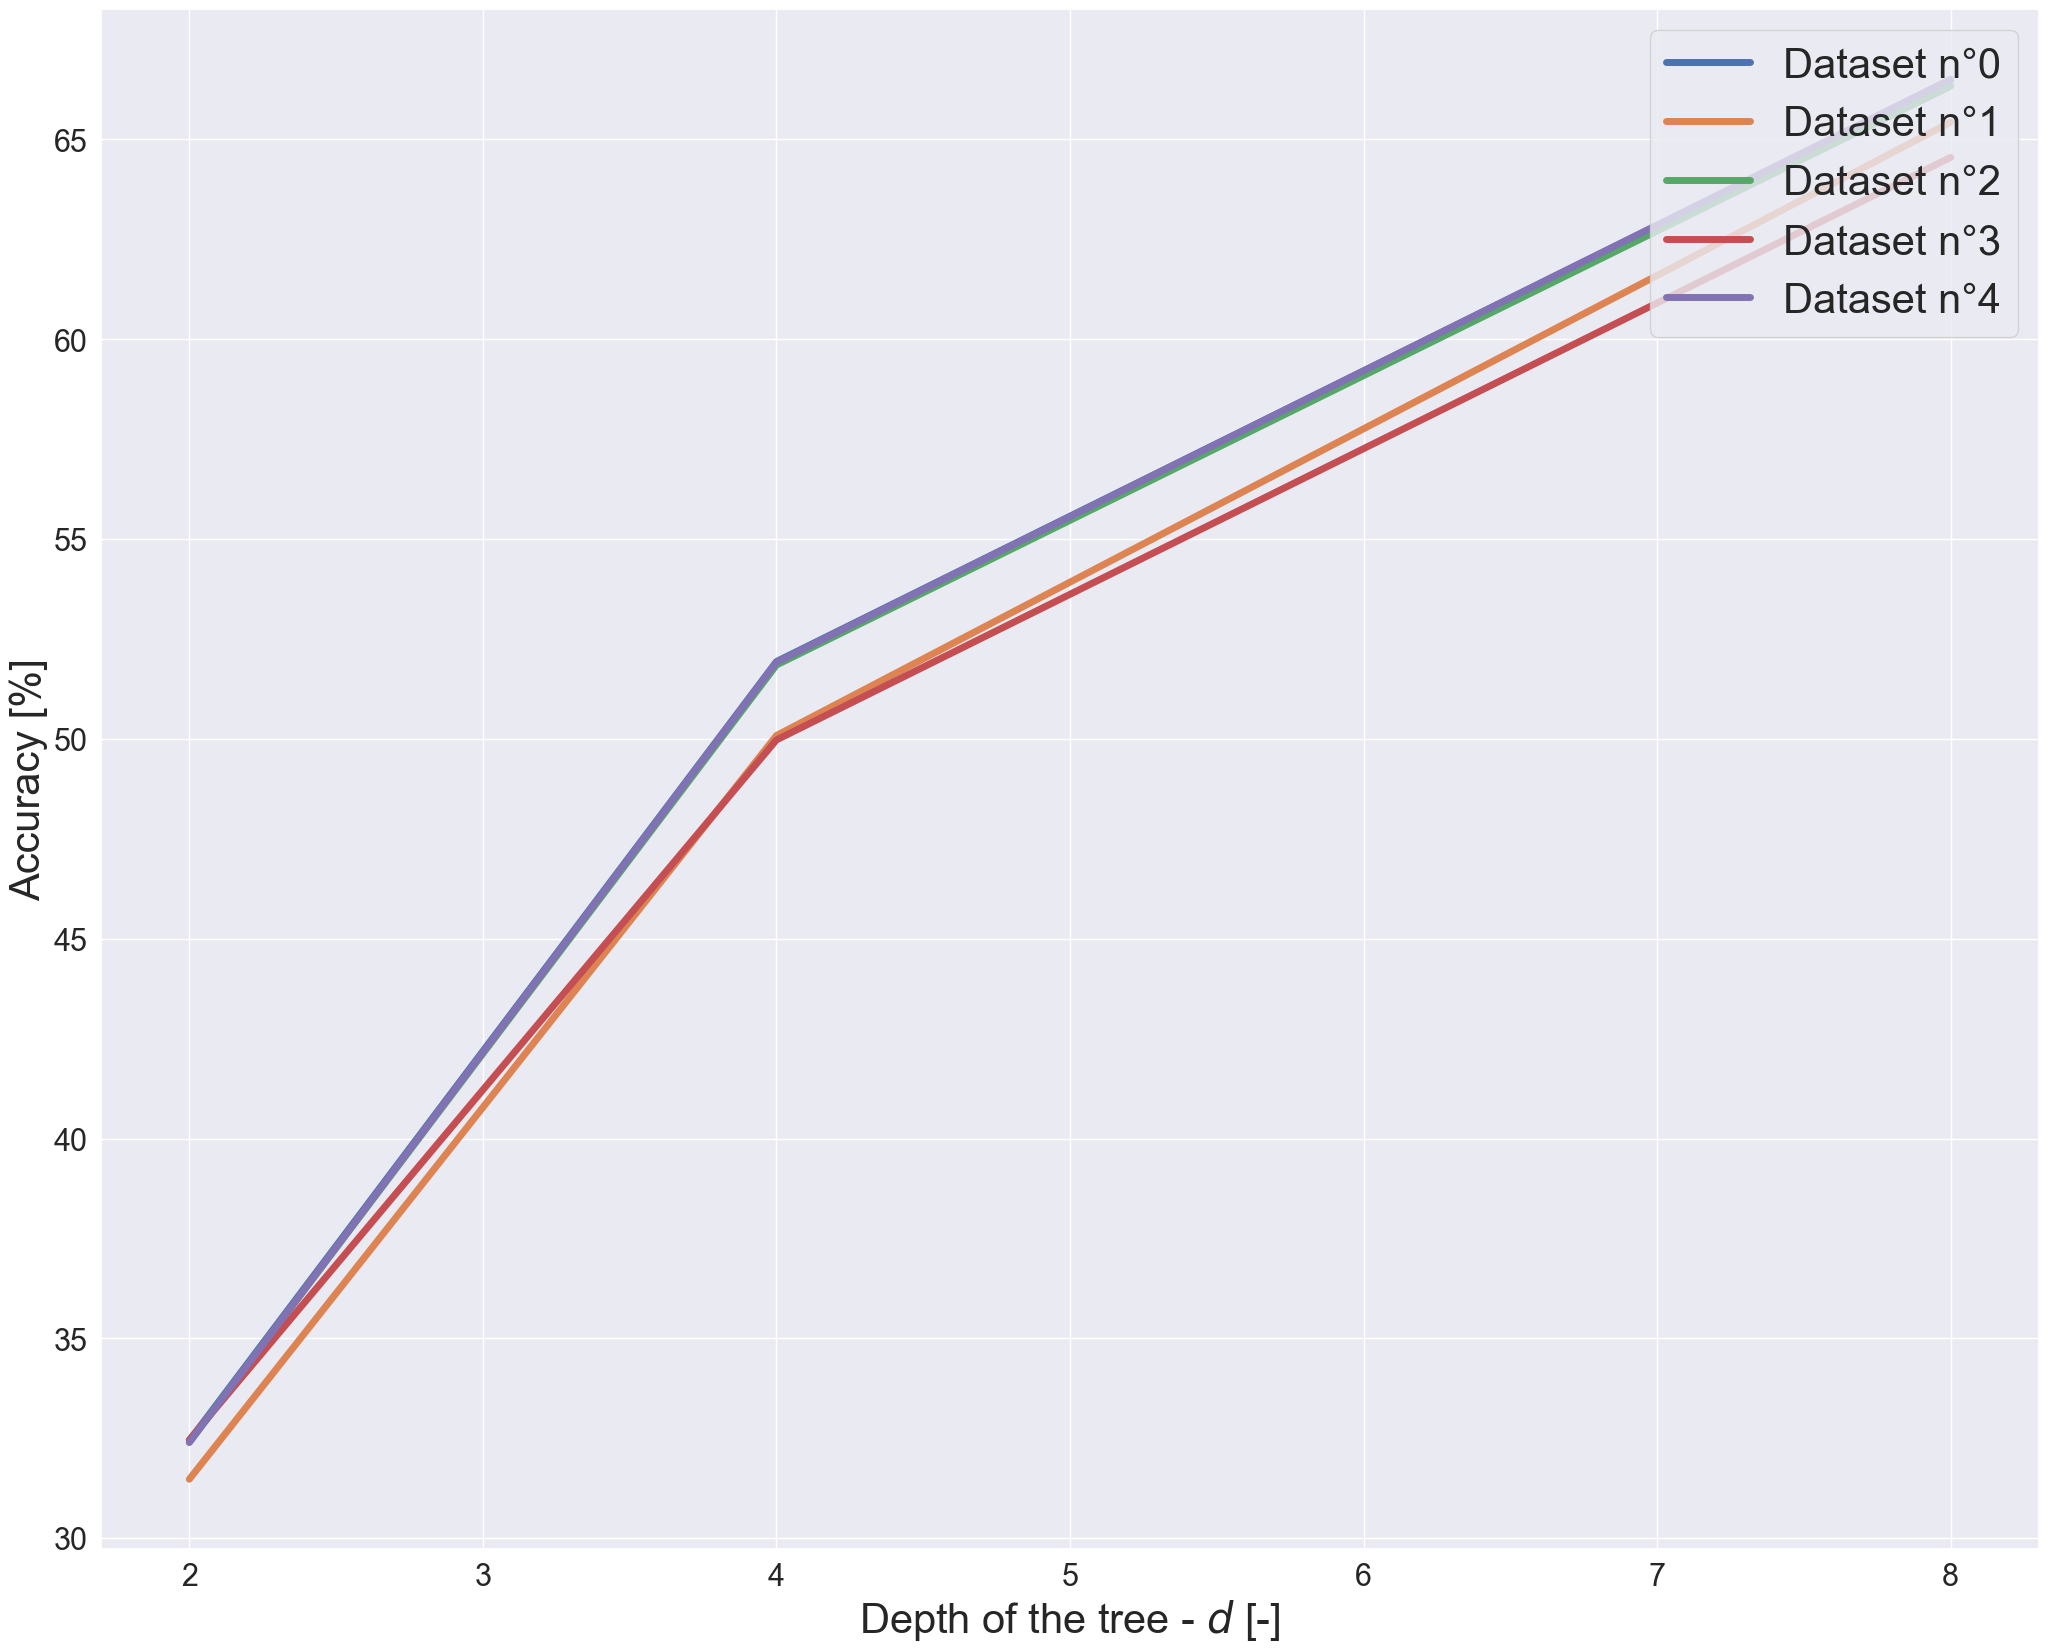

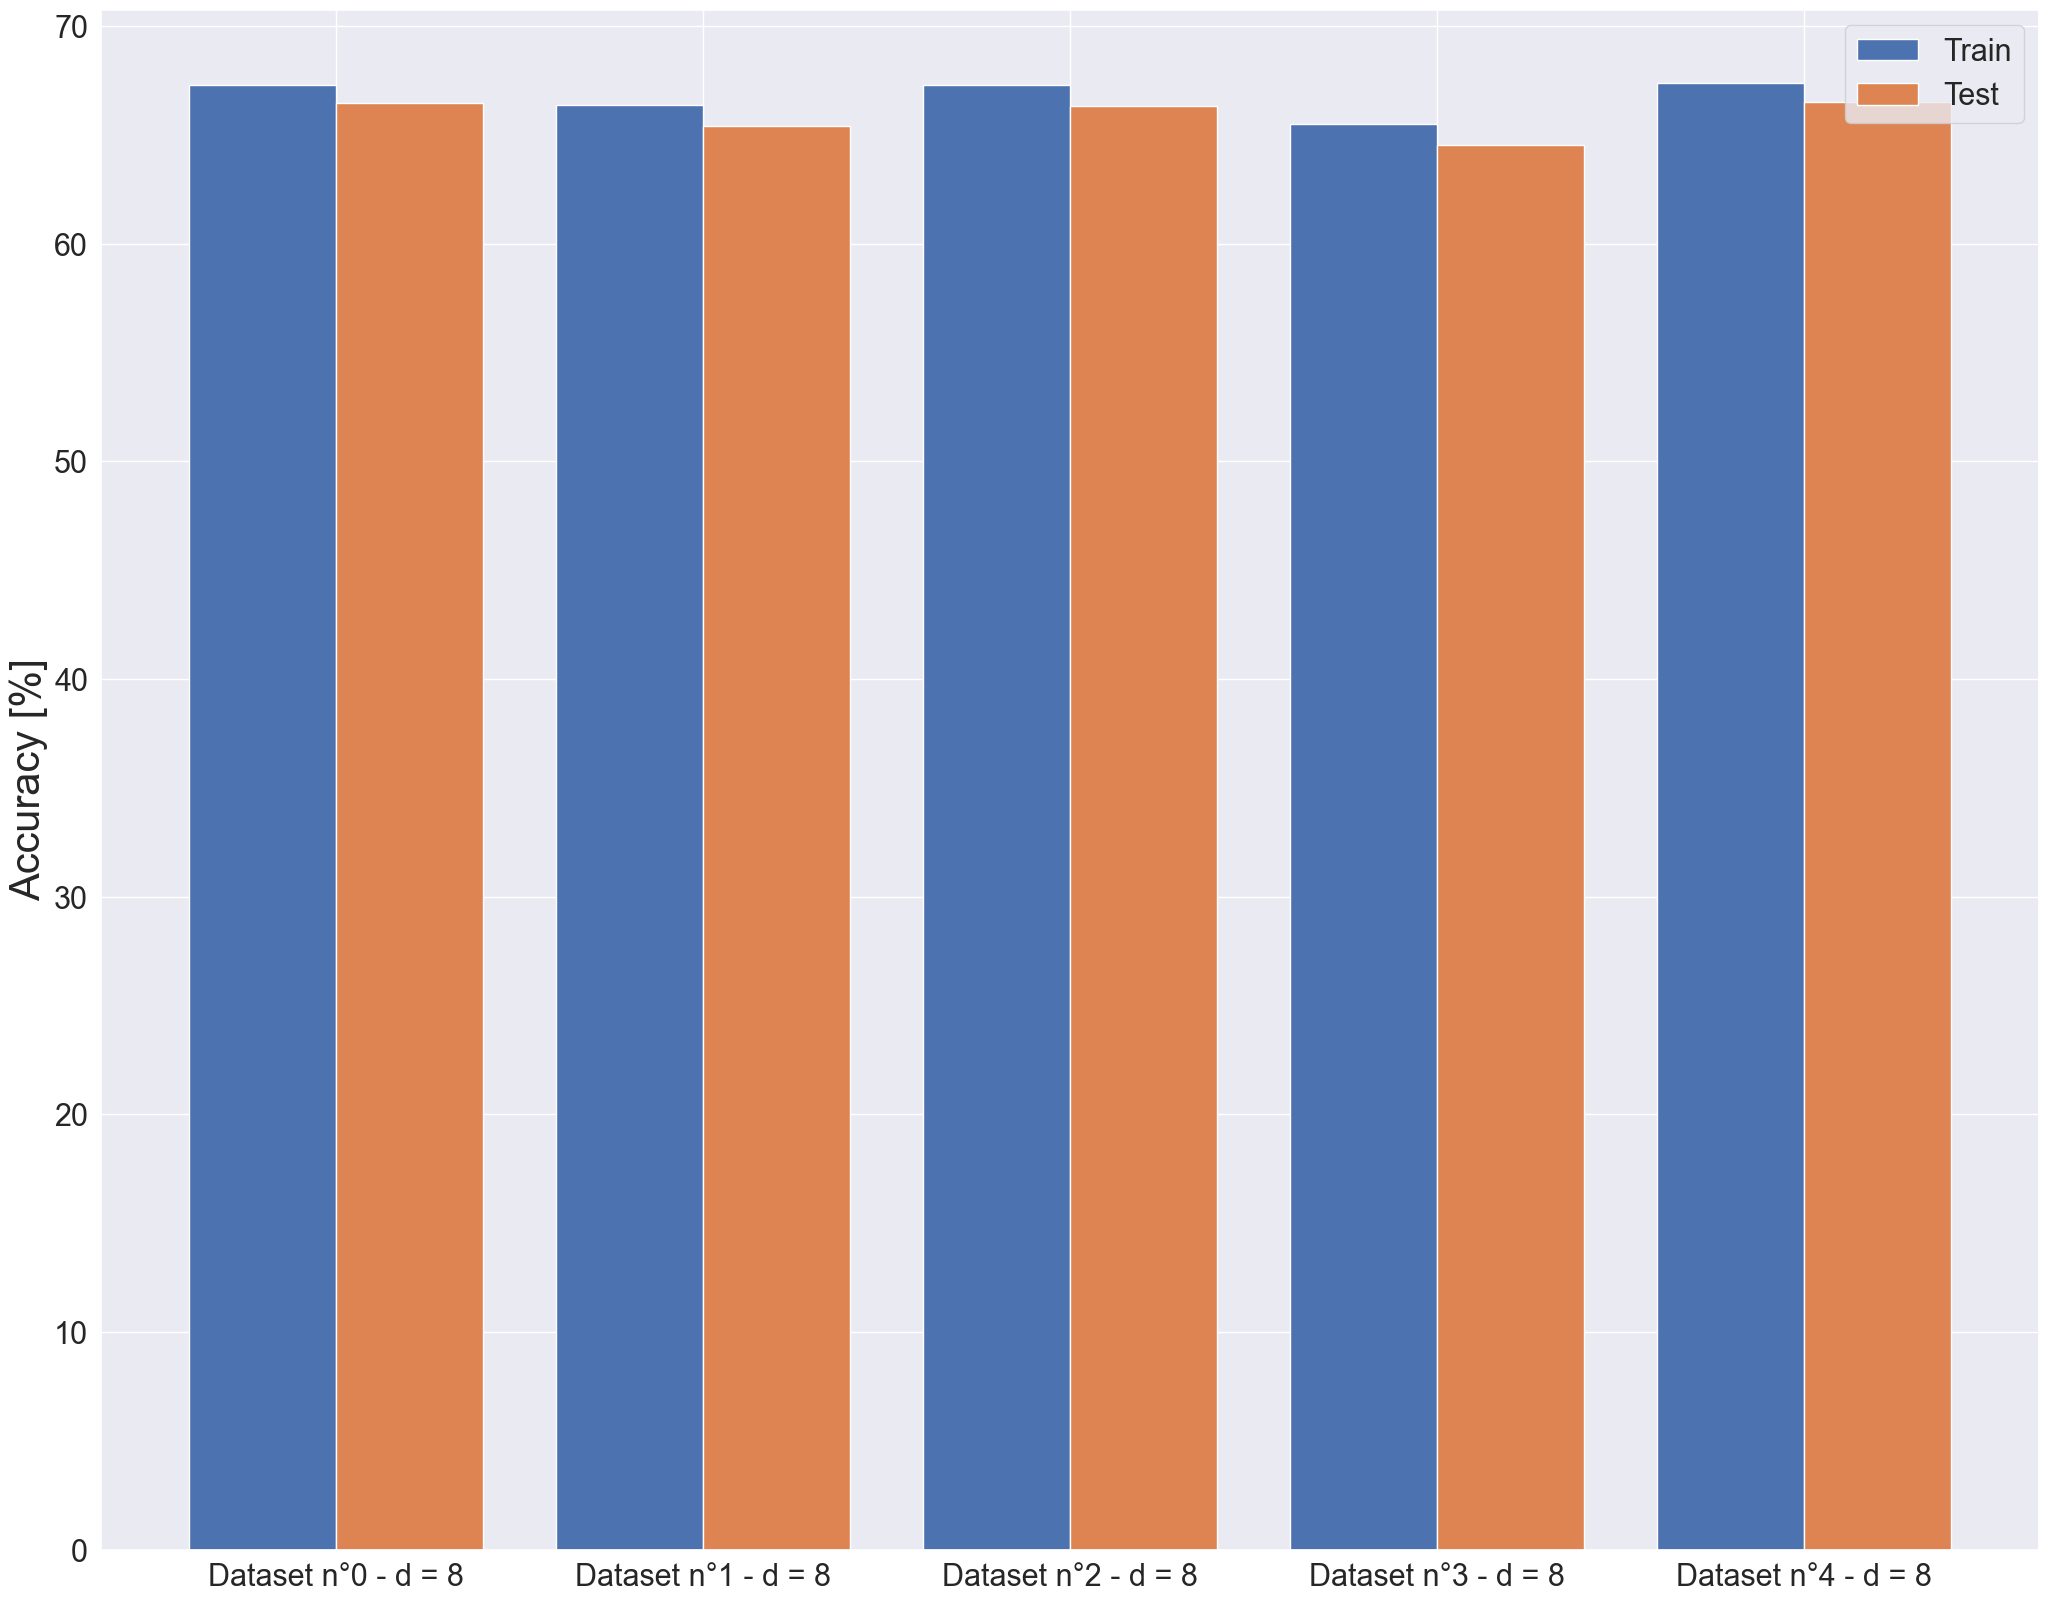

In [20]:
# Plotting the results
modelPlotResults(max_depth, rf_accuracy_train, rf_accuracy_test, 
                 xlabel = "Depth of the tree - $d$ [-]", fontsize = 30, 
                 param_name = "d", save_path = "graphs/rf/rf")

In [42]:
# -- ERROR FUNCTIONS --
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score


def computeError(n_y_true, n_y_pred, param_best = 0, param_name = "UNKNOWN", fontsize = 20, save_path = "graphs/"):
    """Compute the error to evaluate the performance of the model 

    Parameters
    -----------
    n_y_true: list of np.array
              Ground truth (correct) target values.


    n_y_pred: list of np.array 
              Estimated target values.
    
    param_best: int
                Default value is 0. 


    param_name: str 
                Default value is "UNKOWN"

                
    fontsize : int
                Default value is 20


    save_path: str
                Default : "graphs/"
   
    """

    n_datasets = len(n_y_true)
    mae = []
    rmse = []
    #auc = [[] for i in range(n_datasets)]

    for y_true, y_pred in zip(n_y_true, n_y_pred):
        mae.append(mean_absolute_error(y_true, y_pred))
        rmse.append(mean_squared_error(y_true, y_pred, squared = False))
        #auc.append(roc_auc_score(y_true, y_pred))
    
    # Contains x-axis labels
    x_ax_labels = [f"Dataset n°{i}- {param_name} = {param_best}" for i in range (n_datasets)]

    # Used to make x-axis
    index = [i for i in range(n_datasets)]
    
    
    # Plotting the results
    plt.figure()
    plt.bar([i - 0.2 for i in index], [mae_i * 100 for mae_i in mae], 0.4, label = "Mean Absolute Error")
    plt.bar([i + 0.2 for i in index], [rmse_i * 100 for rmse_i in rmse], 0.4, label = "Root Mean squared error")
    plt.xticks(index, x_ax_labels)
    plt.ylabel("Error [%]", fontsize = fontsize)
    plt.legend()
    plt.savefig(f"{save_path}Error.pdf")
    plt.show()

    return 

In [40]:
#-- TEST of ERROR function -- 

n_y_true = []
n_y_pred = []
max_depth = 4
test_size = 0.3
random_state = 69
model = RandomForestRegressor(max_depth = max_depth, n_estimators = 10)
for X, y in zip(data_X_tot, data_Y_tot):
        
        # Final conversion (Numpy and retrieving targets)
        X = X.to_numpy()
        y = y[["TARGETVAR"]].to_numpy().ravel()

        # Retrieving datasets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

        # Fitting the model on current split
        model.fit(X_train, y_train)
        n_y_pred.append(model.predict(X_test))
        n_y_true.append(y_test)



[0, 1, 2, 3, 4]
[0.17021316921135365, 0.17425338608820695, 0.1692667593158612, 0.174790220319617, 0.16862223335833154]
[0.21496412606307172, 0.21952481236593457, 0.21363892917656951, 0.2191745052853528, 0.21289804378110128]


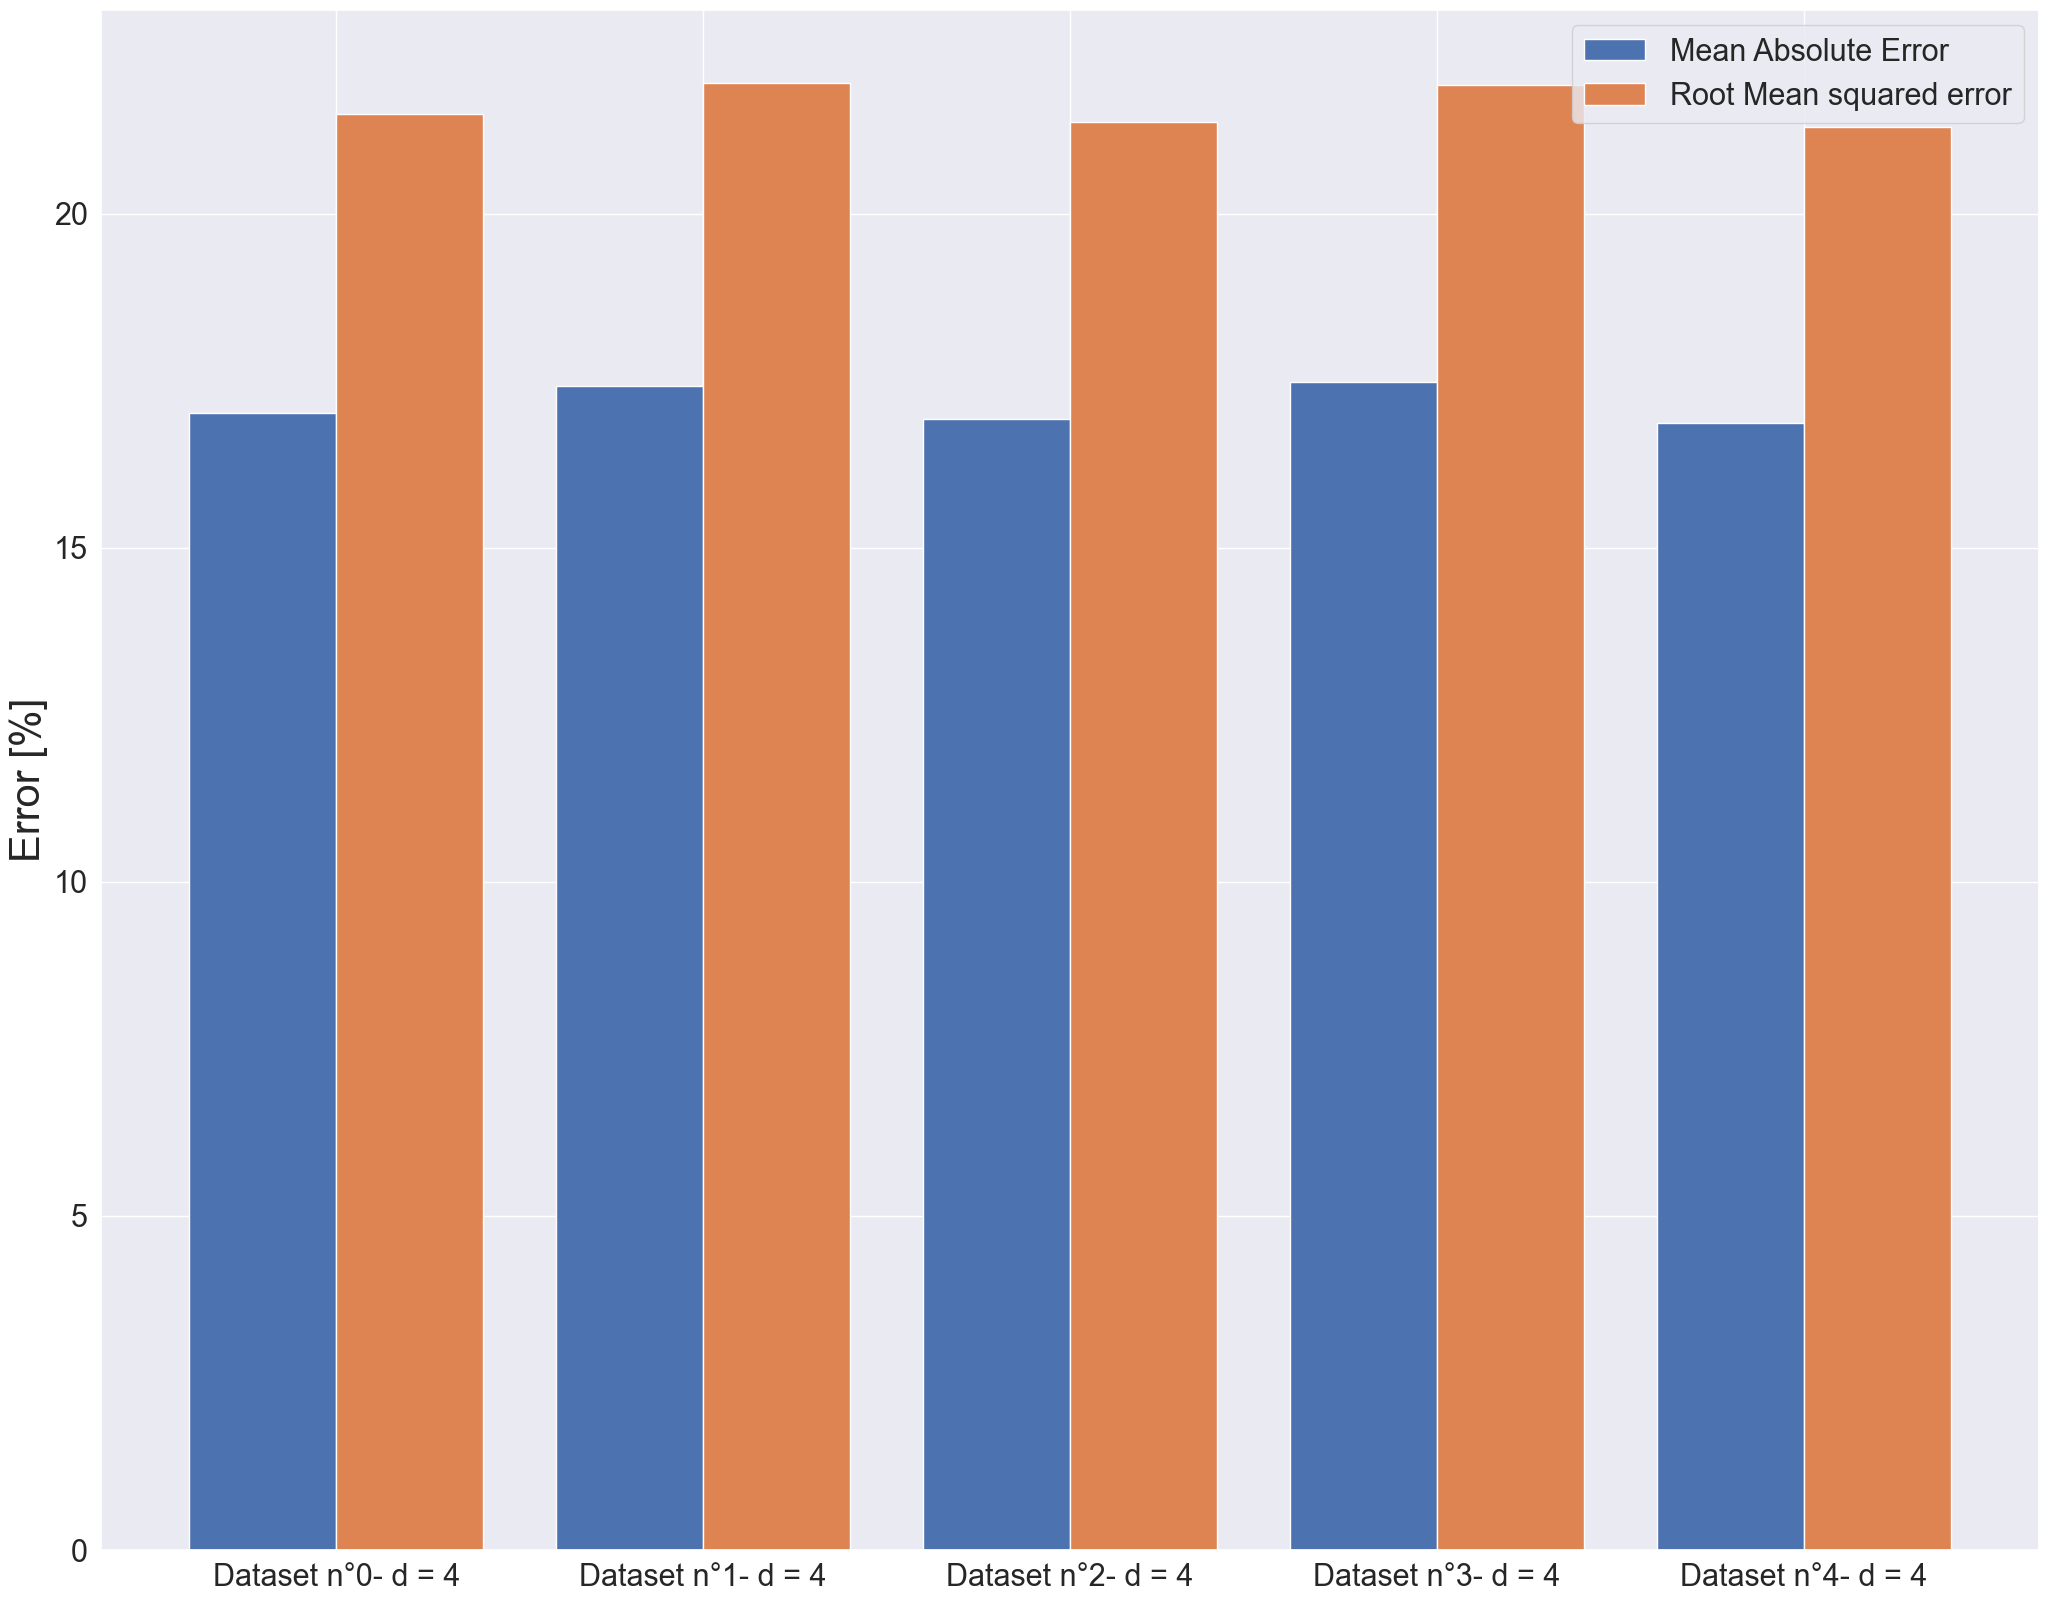

In [43]:
computeError(n_y_true, n_y_pred, param_best = max_depth, param_name = "d", fontsize = 30, save_path = "graphs/")